# Advanced Shape and Texture

<h1>Advanced Shape and Texture</h1>

<p>
    <b>Quantitative Big Imaging</b> ETHZ: 227-0966-00L
    <br/>
    <b>Part 2</b>
</p>
<br/>

<div class='row'>
    <div class='column23'>
        <p style="font-size:1em;">March 28, 2024</p>
        <br /><br />
        <p style="font-size:1.5em;padding-bottom: 0.25em;">Anders Kaestner</p>  
        <p style="font-size:1em;">Laboratory for Neutron Scattering and Imaging<br />Paul Scherrer Institut</p>
    </div>
    <div class='column13'>
        <img src="../../docs/figures/np_shape_2328381_000000.svg" style="height:300px" />
    </div>
</div>  

## Literature / Useful References

### Books
- Pierre Soille, [Morphological image analysis](https://doi.org/10.1007/978-3-662-03939-7)
- Jean Claude, [Morphometry with R](http://link.springer.com/book/10.1007%2F978-0-387-77789-4) through ETHZ
- John C. Russ, [“The Image Processing Handbook”,(Boca Raton, CRC Press)](http://dx.doi.org/10.1201/9780203881095) 
 
### Papers / Sites
#### Thickness
 - [Hildebrand, T., & Ruegsegger, P. (1997). A new method for the model-independent assessment of thickness in three-dimensional images. Journal of Microscopy, 185(1), 67–75.](https://doi.org/10.1046/j.1365-2818.1997.1340694.x)
#### Curvature
   - [Mean curvature](http://mathworld.wolfram.com/MeanCurvature.html)
   - "Computation of Surface Curvature from Range Images Using Geometrically Intrinsic Weights"*, T. Kurita and P. Boulanger, 1992.
  - http://radiomics.io

## Outline

- Motivation (Why and How?)
- What are Distance Maps?
- What are thickness maps?

***

- Characteristic Shapes
- Texture Analysis

## Learning Objectives

### Motivation (Why and How?)

#### Objects
- How can we measure sizes in complicated objects?
- How do we measure sizes relavant for diffusion or other local processes?

- How do we investigate surfaces in more detail and their shape?
- How can we compare shape of complex objects when they grow?
 - Are there characteristic shape metrics?
 
*** 
#### Patterns
- How to we quantify patterns inside images?
- How can compare between different patterns?
- How can we quantify as radiologists say *looking evil*?

## Let's load some modules for the notebook

In [1]:
import os
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../common')
import plotsupport as ps


from scipy import ndimage
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from scipy.ndimage import distance_transform_edt
import skimage.io as io

import skimage.transform
from skimage.feature.texture import graycomatrix, graycoprops
from skimage.util            import montage as montage2d
from skimage.morphology      import binary_opening, binary_closing, disk
from skimage.io              import imread
from skimage.filters         import gaussian
from skimage                 import measure
from skimage.color           import label2rgb

from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import seaborn as sns
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

import ipyvolume as p3

%matplotlib inline


# Distance Maps: What are they?

A distance map is: 
- A map (or image) of distances. 
- Each point in the map is the distance that point is from a given feature of interest (surface of an object, ROI, center of object, etc)
- Different metrics are used:
    - Euclidean (and approximations)
    - City block (4-connected)
    - Checkerboard (8-connected)

## What does a distance map look like?

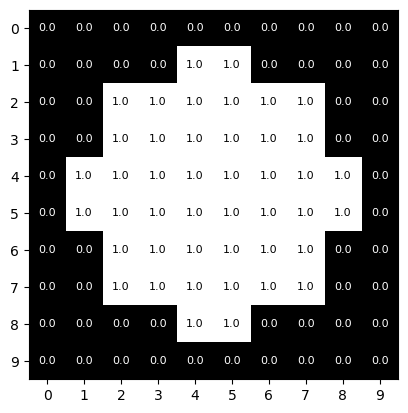

In [2]:
def generate_dot_image(size=100, rad_a=1, rad_b=None):
    xx, yy = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    if rad_b is None:
        rad_b = rad_a
    return np.sqrt(np.square(xx/rad_a)+np.square(yy/rad_b)) <= 1.0


img_bw = generate_dot_image(10, 0.8)


ps.heatmap(img_bw,cmap='gray',fontsize=8,bgbox=False,precision=1);plt.gca().set_aspect(aspect='equal')

### The Euclidean distance map

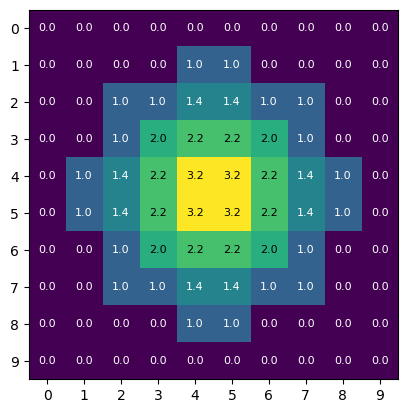

In [3]:
dmap = ndimage.distance_transform_edt(img_bw)

ps.heatmap(dmap,cmap='viridis',fontsize=8,bgbox=False,precision=1)

### The distance map depends on the neighborhood

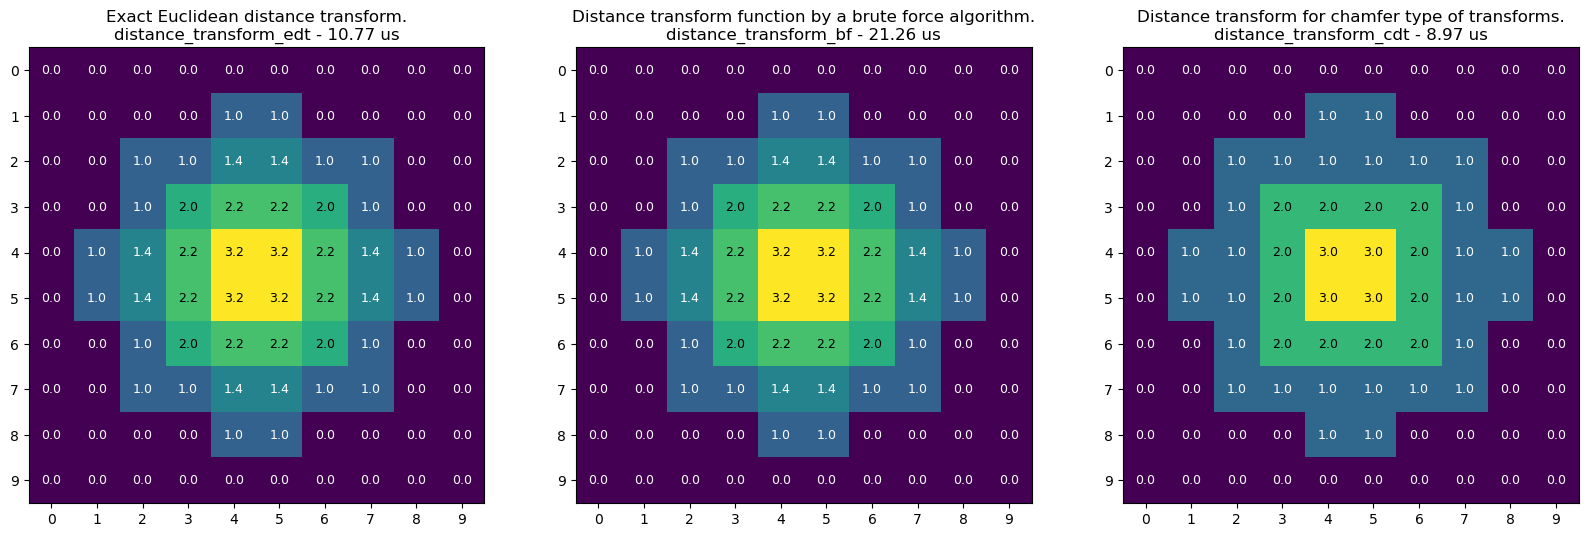

In [4]:
from timeit import timeit
dmap_list = [ndimage.distance_transform_edt,
             ndimage.distance_transform_bf, ndimage.distance_transform_cdt]
fig, m_axs = plt.subplots(1, len(dmap_list), figsize=(20, 6))
for dmap_func, c_ax in zip(dmap_list, m_axs):
    ms_time = timeit(lambda: dmap_func(img_bw), number=10000)/10000*1e6
    dmap = dmap_func(img_bw)
    
    ps.heatmap(dmap,cmap='viridis',fontsize=9,bgbox=False,precision=1,ax=c_ax)
    c_ax.set_title('{}\n{} - {} us'.format(dmap_func.__doc__.split('\n')[1].strip(),
                                           dmap_func.__name__,
                                           '%2.2f' % ms_time))

### Distance maps in python

In [5]:
help(ndimage.distance_transform_edt)

Help on function distance_transform_edt in module scipy.ndimage._morphology:

distance_transform_edt(input, sampling=None, return_distances=True, return_indices=False, distances=None, indices=None)
    Exact Euclidean distance transform.
    
    This function calculates the distance transform of the `input`, by
    replacing each foreground (non-zero) element, with its
    shortest distance to the background (any zero-valued element).
    
    In addition to the distance transform, the feature transform can
    be calculated. In this case the index of the closest background
    element to each foreground element is returned in a separate array.
    
    Parameters
    ----------
    input : array_like
        Input data to transform. Can be any type but will be converted
        into binary: 1 wherever input equates to True, 0 elsewhere.
    sampling : float, or sequence of float, optional
        Spacing of elements along each dimension. If a sequence, must be of
        length equal

## Why does speed matter?
As for the question why speed matters, 
- for small images clearly the more efficient approaches don't make much of a difference, 
- how about data from a Synchrotron measurement 2160x2560x2560 (SLS)?
- even worse when we have series of large volumes...

Now, time becomes much more important

### Extrapolated execution time

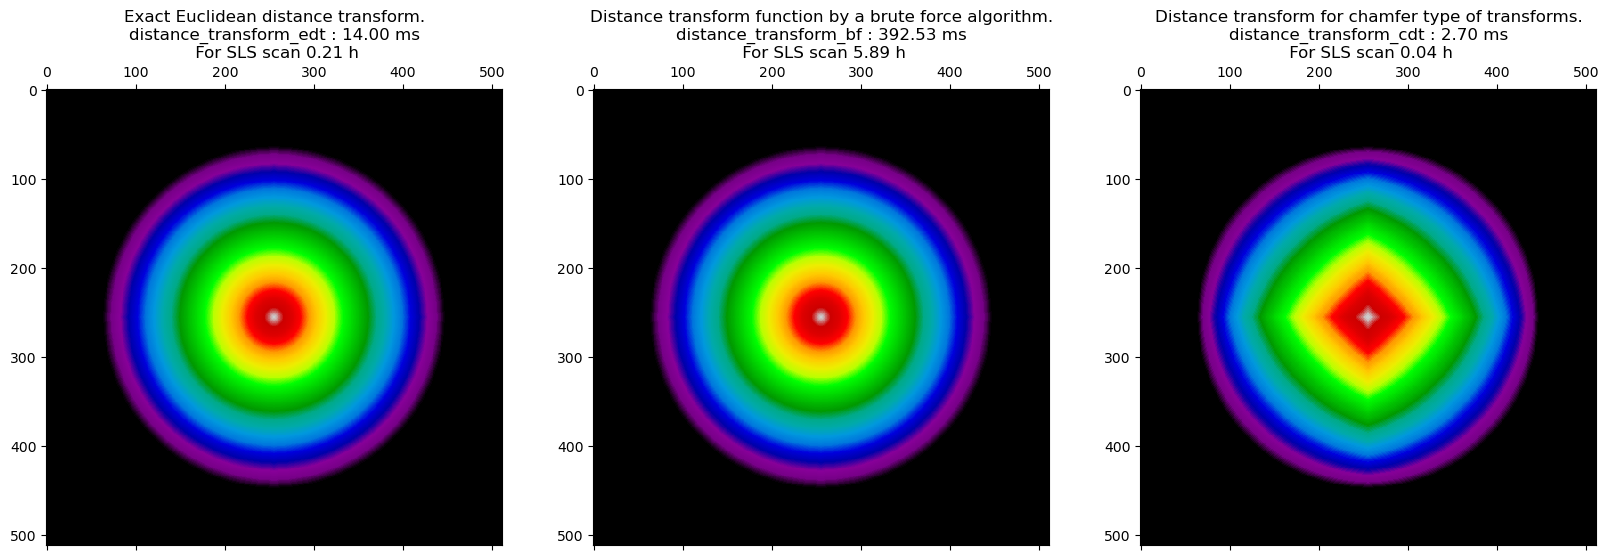

In [6]:
img_bw = generate_dot_image(512, 0.75)
sls_fact = 2160*2560*2560/np.prod(img_bw.shape)
dmap_list = [ndimage.distance_transform_edt,
             ndimage.distance_transform_bf, ndimage.distance_transform_cdt]
fig, m_axs = plt.subplots(1, len(dmap_list), figsize=(20, 6))
for dmap_func, c_ax in zip(dmap_list, m_axs):
    ms_time = timeit(lambda: dmap_func(img_bw), number=1)*1e3
    dmap = dmap_func(img_bw)
    c_ax.matshow(dmap, cmap='nipy_spectral')
    c_ax.set_title('{0}\n{1} : {2:0.2f} ms\n For SLS scan {3:0.2f} h'.format(dmap_func.__doc__.split('\n')[1].strip(),
                                                               dmap_func.__name__,
                                                               ms_time,
                                                               (ms_time*sls_fact/3600/1e3)))

## Distance map - Definition
If we start with an image as a collection of points divided into two categories 
- $Im(x,y)=$ {Foreground, Background}
- We can define a distance map operator ($dist$) that transforms the image into a distance map

$$ dist(\vec{x}) = \textrm{min}(||\vec{x}-\vec{y}|| \forall \vec{y} \in \textrm{Background}) $$

We will use Euclidean distance $||\vec{x}-\vec{y}||$ for this class but there are other metrics which make sense when dealing with other types of data like Manhattan/City-block or weighted metrics.

In [7]:
def simple_distance_iteration(last_img):
    cur_img = last_img.copy()
    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x, y] >= 0:
                i_xy = last_img[x, y]
                for xp in [-1, 0, 1]:
                    if (x+xp < last_img.shape[0]) and (x+xp >= 0):
                        for yp in [-1, 0, 1]:
                            if (y+yp < last_img.shape[1]) and (y+yp >= 0):
                                
                                p_dist = np.sqrt(np.square(xp)+np.square(yp)) # Distance metric
                                
                                if cur_img[x+xp, y+yp] > (last_img[x, y]+p_dist):
                                    cur_img[x+xp, y+yp] = last_img[x, y]+p_dist
    return cur_img

### A test image for distance transform

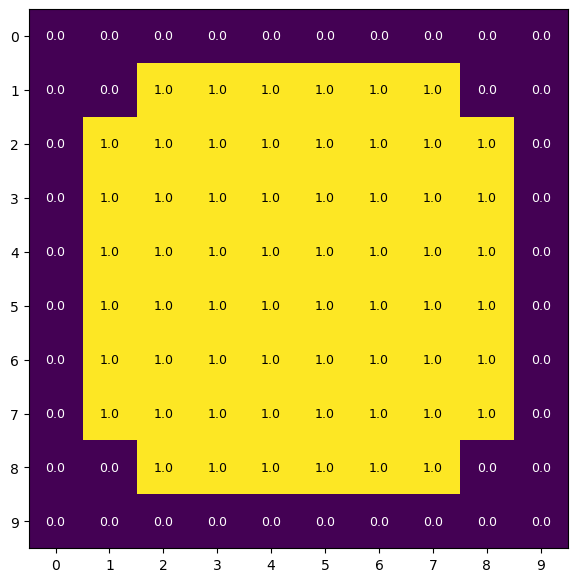

In [8]:
fig, ax=plt.subplots(1,1, figsize=(7,7))
img_bw = generate_dot_image(10, 1.0)
plt.imshow(img_bw)

ps.heatmap(img_bw,cmap='viridis',fontsize=9,bgbox=False,precision=1,ax=ax)
ax.set_aspect(aspect='equal')

### Animating the iterations

In [9]:
fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
img_base = (img_bw*255).astype(np.float32)
img_list = [img_base]
for i in range(5):
    img_base = simple_distance_iteration(img_base)
    img_list += [img_base]


def update_frame(i):
    plt.cla()
    ps.heatmap(img_list[i],cmap='nipy_spectral',fontsize=9,bgbox=False,precision=1,ax=c_ax,vmin=0, vmax=5)
    c_ax.set_title('Iteration #{}'.format(i+1))
# write animation frames
anim_code = FuncAnimation(fig, update_frame, frames=5,interval=1000,repeat_delay=2000).to_html5_video()
plt.close('all')
HTML(anim_code)

## Distance Maps: Types

Using this rule a distance map can be made for the euclidean metric 


Similarly the Manhattan or city block distance metric can be used where the distance is defined as 
$$ \sum_{i} |\vec{x}-\vec{y}|_i $$

In [10]:
def simple_distance_iteration(last_img):
    cur_img = last_img.copy()
    for x in range(last_img.shape[0]):
        for y in range(last_img.shape[1]):
            if last_img[x, y] >= 0:            # Is img(x,y) foreground? 
                i_xy = last_img[x, y]
                for xp in [-1, 0, 1]:          # Scan neighborhood
                    if (x+xp < last_img.shape[0]) and (x+xp >= 0):
                        for yp in [-1, 0, 1]:
                            if (y+yp < last_img.shape[1]) and (y+yp >= 0):
                                
                                p_dist = np.abs(xp)+np.abs(yp)     # Distance metric
                                
                                if cur_img[x+xp, y+yp] > (last_img[x, y]+p_dist):
                                    cur_img[x+xp, y+yp] = last_img[x, y]+p_dist
    return cur_img

### Animating City-block distance

In [11]:
fig, c_ax = plt.subplots(1, 1, figsize=(5, 5), dpi=120)
img_base = (img_bw*255).astype(np.float32)
img_list = [img_base]
for i in range(5):
    img_base = simple_distance_iteration(img_base)
    img_list += [img_base]


def update_frame(i):
    plt.cla()
    ps.heatmap(img_list[i],cmap='nipy_spectral',fontsize=9,bgbox=False,precision=1,ax=c_ax,vmin=0, vmax=5)
    c_ax.set_title('Iteration #{}'.format(i+1))
    c_ax.set_aspect(1)


# write animation frames
anim_code = FuncAnimation(fig, update_frame, frames=5,
                          interval=1000, repeat_delay=2000).to_html5_video()
plt.close('all')
HTML(anim_code)

## Distance Maps: Precaution


The distance map is one of the crictical points where the resolution of the imaging system is important. 
- We measure distances computationally in pixels or voxels
- but for them to have a meaning physically they must be converted
 - Isotropic imaging (1 $\mu$ m x 1$\mu$ m x 1 $\mu$ m) is __fine__
 
***

### Anisotropic

Options to handle anisotropic voxels:

- as part of filtering, resample and convert to an isotropic scale. 

- custom distance map algorithms 
    - use the side-lengths of the voxels to calculate distance rather than assuming 1x1x1

## What does the Distance Maps show?


We can create 2 distance maps

1. Foreground $\rightarrow$ Background 
 - Information about the objects size and interior

1. Background $\rightarrow$ Foreground 
 - Information about the distance / space between objects


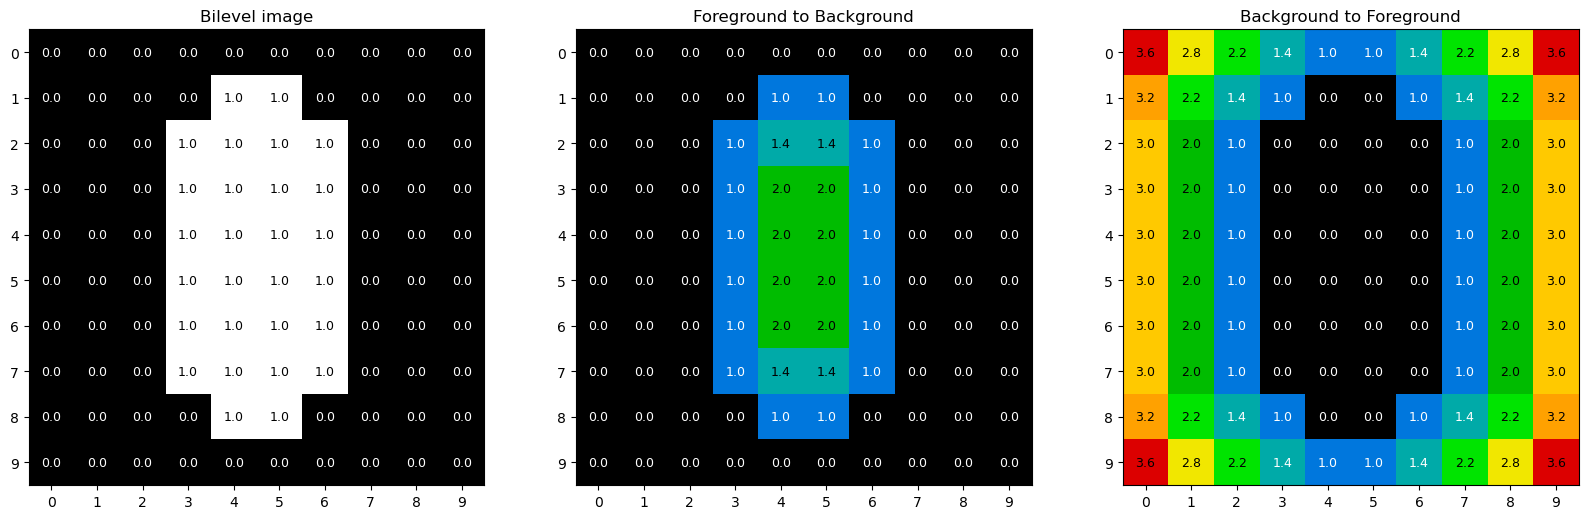

In [12]:
def generate_dot_image(size=100, rad_a=1, rad_b=None):
    xx, yy = np.meshgrid(np.linspace(-1, 1, size), np.linspace(-1, 1, size))
    if rad_b is None:
        rad_b = rad_a
    return np.sqrt(np.square(xx/rad_a)+np.square(yy/rad_b)) <= 1.0


img_bw = generate_dot_image(10, 0.5, 1.0)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

ps.heatmap(img_bw,cmap='gray',fontsize=9,bgbox=False,precision=1,ax=ax1)
ax1.set_title('Bilevel image')

ps.heatmap(ndimage.distance_transform_edt(img_bw),cmap='nipy_spectral',fontsize=9,bgbox=False,precision=1,ax=ax2,vmin=0, vmax=4)
ax2.set_title('Foreground to Background')

ps.heatmap(ndimage.distance_transform_edt(1-img_bw),cmap='nipy_spectral',fontsize=9,bgbox=False,precision=1,ax=ax3,vmin=0, vmax=4)
ax3.set_title('Background to Foreground');

## Distance Map

One of the most useful components of the distance map is that it is _relatively_ insensitive to small changes in connectivity.
- Component Labeling would find radically different results for these two images
 - One has 4 small circles
 - One has 1 big blob

### Some code for the demo

In [13]:
def update_frame(i):
    [tax.cla() for tax in m_axs.flatten()]
    ((c_ax, c_hist, c_dmean), (c_lab, c_labhist, c_lmean)) = m_axs
    c_ax.imshow(img_list[i],vmin=0,vmax=5, cmap='nipy_spectral')

    c_ax.set_title('DMap #{}'.format(i+1))
    c_hist.hist(img_list[i].ravel(),
                np.linspace(0, 3, 6))
    c_hist.set_title('Mean: %2.2f\nStd: %2.2f' % (np.mean(img_list[i][img_list[i] > 0]),
                                                  np.std(img_list[i][img_list[i] > 0])))

    c_dmean.plot(range(i+1), [np.mean(img_list[k][img_list[k] > 0])
                              for k in range(i+1)], 'r+-')
    c_dmean.set_ylim(0, 2)
    c_dmean.set_title('Avergage Distance')

    lab_img = ndimage.label(img_list[i] > 0)[0]
    c_lab.imshow(lab_img,vmin=0,vmax=2, cmap='nipy_spectral')

    c_lab.set_title('Component Labeled')

    def avg_area(c_img):
        l_img = ndimage.label(c_img > 0)[0]
        return np.mean([np.sum(l_img == k) for k in range(1, l_img.max()+1)])
    
    n, _, _ = c_labhist.hist(lab_img[lab_img > 0].ravel(), [
                             0, 1, 2, 3], rwidth=0.8)
    c_labhist.set_title('# Components: %d\nAvg Area: %d' %
                        (lab_img.max(), avg_area(img_list[i])))

    c_lmean.plot(range(i+1),
                 [avg_area(img_list[k]) for k in range(i+1)], 'r+-')
    c_lmean.set_ylim(0, 150)
    c_lmean.set_title('Average Area')

fig, m_axs = plt.subplots(2, 3, figsize=(12, 8))

img_list = []
for i in np.linspace(0.6, 1.3, 7):
    img_bw = np.concatenate([generate_dot_image(12, 0.7, i),
                             generate_dot_image(12, 0.6, i)], 0)
    img_base = ndimage.distance_transform_edt(img_bw)
    img_list += [img_base]
    
# write animation frames
anim_code = FuncAnimation(fig,
                          update_frame,
                          frames=len(img_list)-1,
                          interval=1000,
                          repeat_delay=2000).to_html5_video()
plt.close('all')

### Animate the distances

In this example we grow two objects and observe how the maximum distance changes compared to the area of labeled object. Initially, the two metrics behave similarly. It becomes interesting when the two objects grow into each other. Then the labeling only finds a single object and the area is double compared to before the merge. The distance, however, stay within the same magnitude thoughout the entire growing sequence.

In [14]:
HTML(anim_code)

# Distance Map of Real Images

We now have a basic idea of how the distance map works we can now try to apply it to real images

## The bone slice

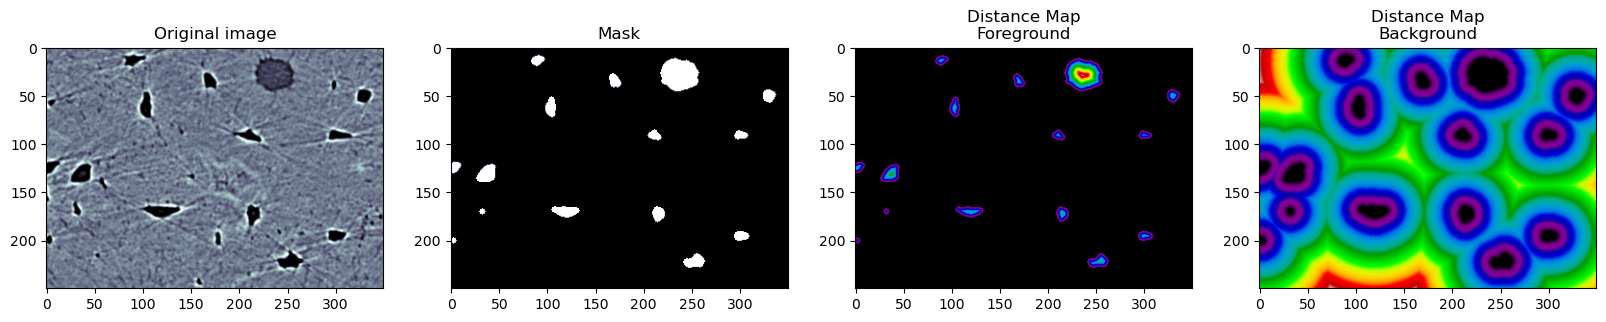

In [15]:
bw_img = imread("../Lecture-05/figures/bonegfiltslice.png")

thresh_img = binary_closing(binary_opening(bw_img < 90, disk(3)), disk(5))
fg_dmap = distance_transform_edt(thresh_img)
bg_dmap = distance_transform_edt(1-thresh_img)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 6), dpi=100)
ax1.imshow(bw_img, cmap='bone'),           ax1.set_title('Original image')
ax2.imshow(thresh_img, cmap='bone'),       ax2.set_title('Mask') 
ax3.imshow(fg_dmap, cmap='nipy_spectral'); ax3.set_title('Distance Map\nForeground');
ax4.imshow(bg_dmap, cmap='nipy_spectral'); ax4.set_title('Distance Map\nBackground');

## The cortex

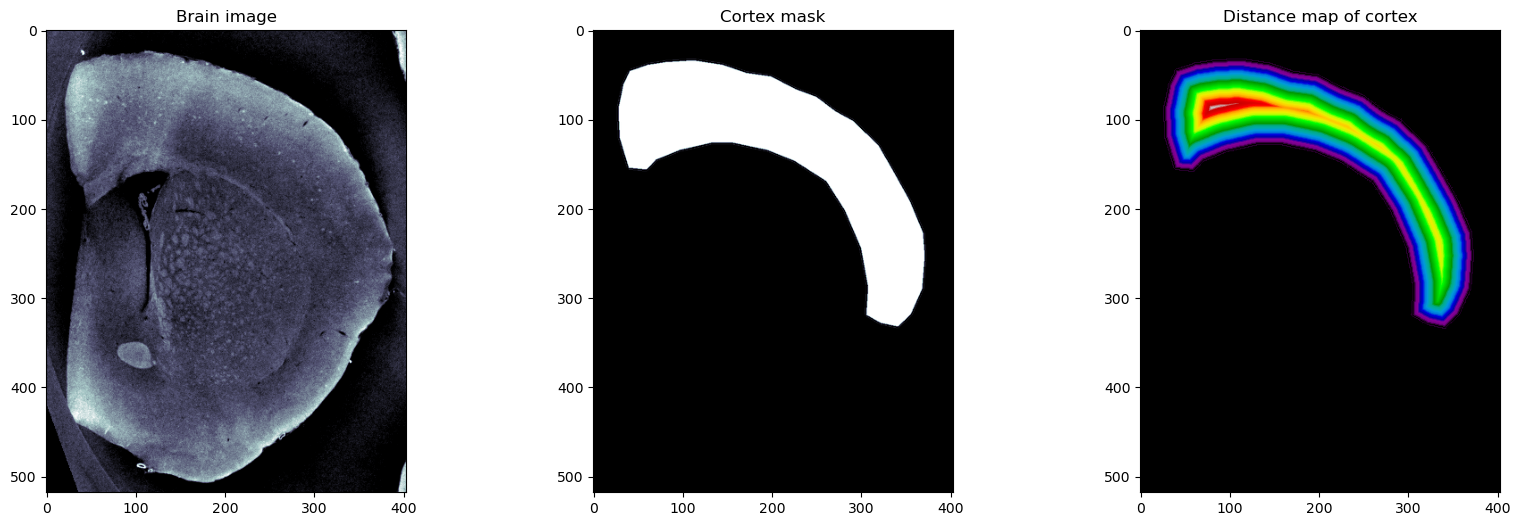

In [16]:
cortex_img  = imread("figures/example_poster.tif")[::2, ::2]/2048
cortex_mask = imread("figures/example_poster_mask.tif")[::1, ::1, 0]/255.0
cortex_dmap = distance_transform_edt(cortex_mask,distances=True)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6), dpi=100)

ax1.imshow(cortex_img, cmap='bone'), ax1.set_title('Brain image')
ax2.imshow(cortex_mask, cmap='bone'), ax2.set_title('Cortex mask')
ax3.imshow(cortex_dmap, cmap='nipy_spectral'); ax3.set_title('Distance map of cortex');

## How can we utilize this information?
- So we can see in the distance map some information about the size of the object, 
- but the raw values and taking a histogram do not seem to provide this very clearly


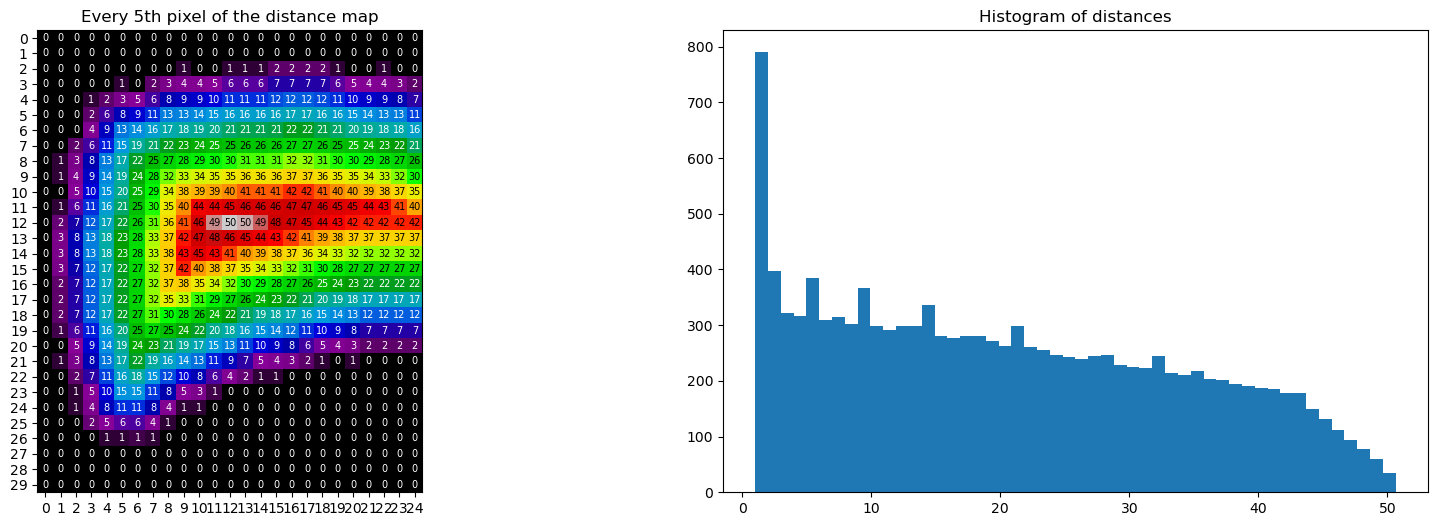

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
cortex_dmap_roi = cortex_dmap[25:175, 25:150]
ps.heatmap(cortex_dmap_roi[::5,::5], ax=ax1, precision=0,bgbox=False, fontsize=7,cmap='nipy_spectral')
ax1.set_title('Every 5th pixel of the distance map')
ax2.hist(cortex_dmap_roi[cortex_dmap_roi > 0].ravel(), 50); ax2.set_title('Histogram of distances');

In [18]:
from skimage.morphology import binary_opening, binary_closing, disk
from scipy.ndimage import distance_transform_edt
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
%matplotlib inline

## [Demo isoline average](../IsolineAverage/IsolineAverage.ipynb)

![](figures/isoprofile.png)

# The thickness map

Thickness is a metric for assessing the size and structure of objects in a very generic manner. 
For every point $\vec{x}$ in the image you find the largest sphere which:
- contains that point
- is entirely contained within the object

The thickness map is quantifying the regional sizes compared to the distance map which describes distances from pixel to pixel. That is, in the thickness map all pixels belonging to a sphere that can be inscribed in the object will have the value of the sphere radius. There will be many overlapping spheres and it is always the largest radius that defines the pixel value.
```{figure} figures/ThickOverview.png
---
scale: 60%
---
The largest sphere inscribed in the object.
```

In the comparison below, you can see that the distance map has a greater representation of short distances while the thickness map has large areas with great distances. 
```{figure} figures/poremap.png
---
scale: 60%
---
Comparing the thickness map to the distance map.
```
The thickness map has many names. So, when you hear terms like pore radius map or pore size map, then it is all the same thing. One little difference would be that the thickness map indicates that you are measuring solid objects while the pore size map focuses on the voids between the objects.

<table>
    <tr>
<td><img src="figures/ThickOverview.png" style="height:300px" /></td>
<td><img src="figures/poremap.png" style="height:300px" /></td>
        </tr>
</table>

Taken from [Hildebrand 1997](https://doi.org/10.1046/j.1365-2818.1997.1340694.x)

- The image shows a typical object
- The sphere centered at point $p$ with a radius $r$ is the largest that fits

## Applications

<div class="row">
<div class="column23">

- Ideal for spherical and cylindrical objects since it shows their radius
- Also relevant for flow and diffusion since it can highlight bottlenecks in structure (then called pore radius map) [Lehmann 2006](https://doi.org/10.2136/vzj2004.0177)
    
</div>
<div class="column13">
<img src="figures/sand_poresize.png" style="height:500px">
</div>    
</div>

## A thickness map implementation

In [19]:
def simple_thickness_func(distance_map):
    dm = distance_map.ravel()
    th_map = distance_map.ravel().copy()
    xx, yy = [v.ravel() for v in np.meshgrid(range(distance_map.shape[1]),
                                             range(distance_map.shape[0]))]

    for idx in np.argsort(-dm):
        dval = dm[idx]
        if dval > 0:
            p_mask = (np.square(xx-xx[idx]) +
                      np.square(yy-yy[idx])) <= np.square(dval)
            p_mask &= th_map < dval
            th_map[p_mask] = dval
    th_map[dm == 0] = 0  # make sure zeros stay zero (rounding errors)
    return th_map.reshape(distance_map.shape)

This is not an efficient implementation as it computes the distance from the current pixel to all pixels in the image. This is repeated for all foreground pixels. It would be smarter to only probe the pixels with the radius of the current pore. This would however lead to a more comlicated algorithm that would require higher level of detail to explain.

## Thickness map on foregrund and background

In [49]:
fg_th_map = simple_thickness_func(fg_dmap)
bg_th_map = simple_thickness_func(bg_dmap)

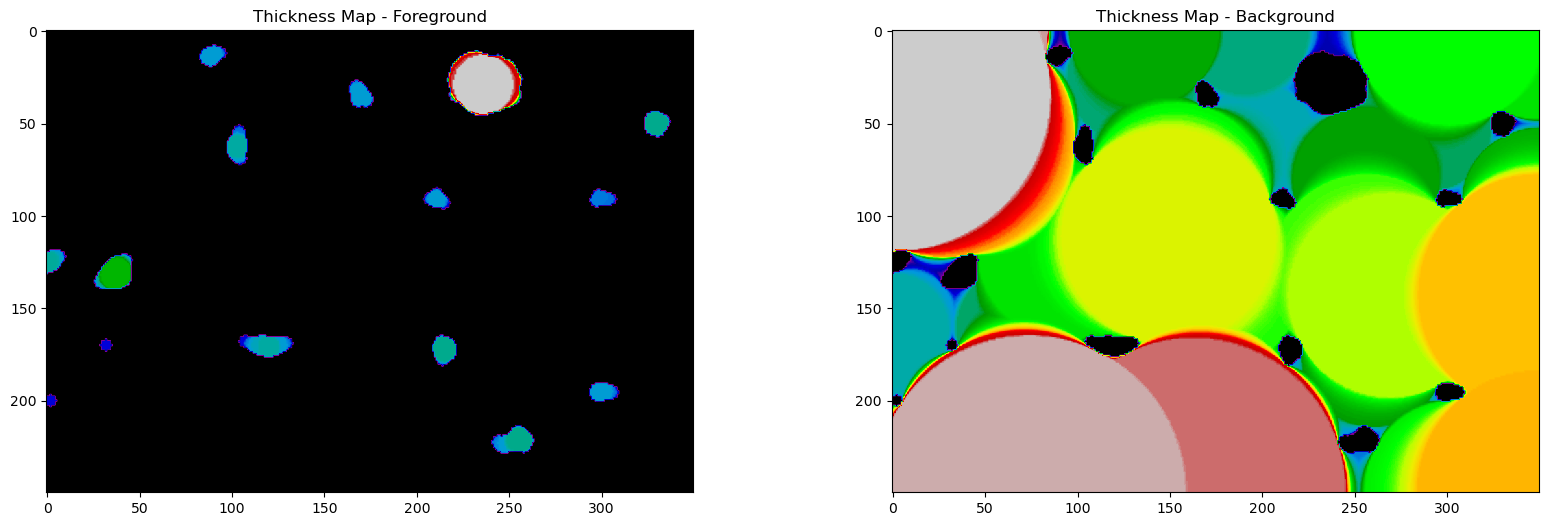

In [50]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 6), dpi=100)

ax3.imshow(fg_th_map, cmap='nipy_spectral'); ax3.set_title('Thickness Map - Foreground');
ax4.imshow(bg_th_map, cmap='nipy_spectral'); ax4.set_title('Thickness Map - Background');

## Thickness distributions

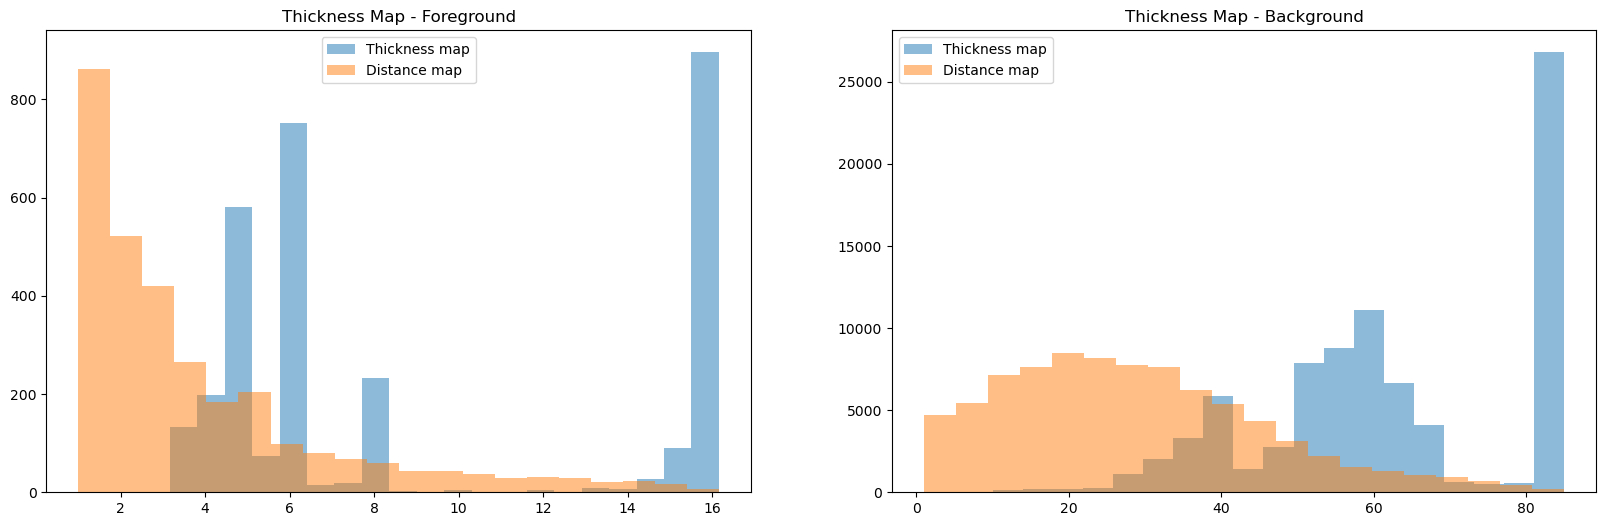

In [48]:
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(20, 6), dpi=100)

ax3.hist(fg_th_map[fg_th_map > 0].ravel(), 20,alpha=0.5, label='Thickness map'); ax3.set_title('Thickness Map - Foreground');
ax3.hist(fg_dmap[fg_dmap > 0].ravel(),bins=20,alpha=0.5, label='Distance map');
ax3.legend()
ax4.hist(bg_th_map[bg_th_map > 0].ravel(), 20,alpha=0.5, label='Thickness map'); ax4.set_title('Thickness Map - Background');
ax4.hist(bg_dmap[bg_dmap > 0].ravel(),bins=20,alpha=0.5, label='Distance map');
ax4.legend();

# Distance Maps in 3D
- Distance maps work in more than two dimensions and can be used in n-d problems. 
- Beyond 3D requires serious thought about what the meaning of this distance is. 

## Let's load a 3D image 

We need some data to demonstrate the distance transform of 3D images. This an image of oblatoid grains which are aligned with the major axis in the vertical direction.

Loaded Image: (154, 150, 150) 255


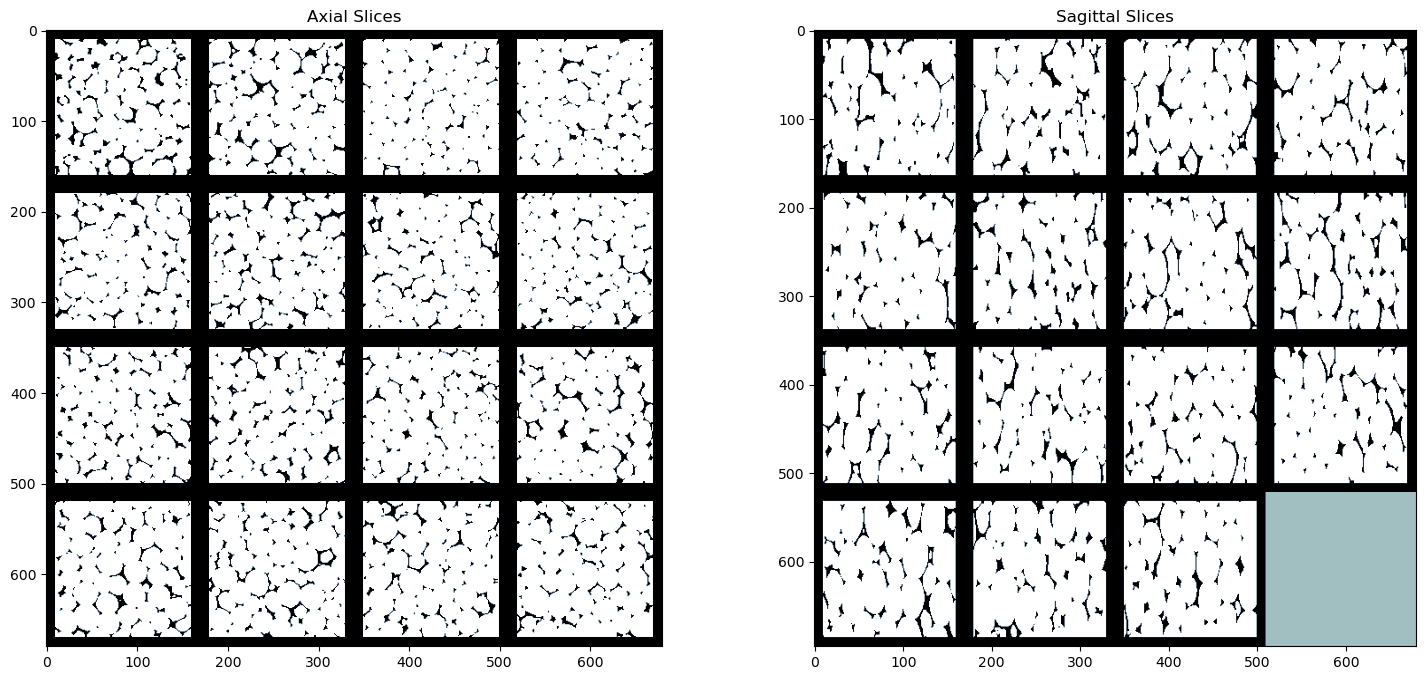

In [21]:
def montage_pad(x): return montage2d(
    np.pad(x, [(0, 0), (10, 10), (10, 10)], mode='constant', constant_values=0))

bw_img = 255 - imread("data/plateau_border.tif")[:, 100:400, 100:400][:, ::2, ::2]
print('Loaded Image:', bw_img.shape, bw_img.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
ax1.imshow(montage_pad(bw_img[::10]), cmap='bone');ax1.set_title('Axial Slices')
ax2.imshow(montage_pad(bw_img.swapaxes(0, 1)[::10]), cmap='bone'); ax2.set_title('Sagittal Slices');

## Inspecting the data in 3D using a surface mesh

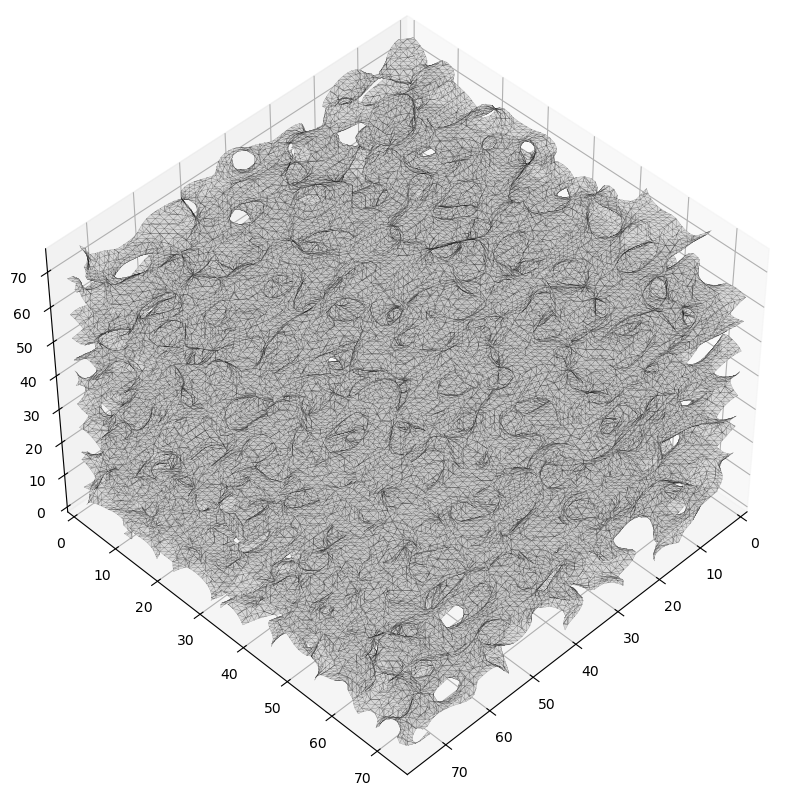

In [22]:
def show_3d_mesh(image, thresholds, edgecolor='none', alpha=0.5):
    p = image[::-1].swapaxes(1, 2)
    cmap = plt.colormaps.get_cmap('nipy_spectral_r')
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    for i, c_threshold in list(enumerate(thresholds)):
        verts, faces, _, _ = measure.marching_cubes(p, c_threshold)
        mesh = Poly3DCollection(verts[faces], alpha=alpha, edgecolor=edgecolor, linewidth=0.1)
        mesh.set_facecolor(cmap(i / len(thresholds))[:3])
        ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0]); ax.set_ylim(0, p.shape[1]); ax.set_zlim(0, p.shape[2])

    ax.view_init(45, 45)
    return fig


smooth_pt_img = gaussian(bw_img[::2, ::2, ::2]*1.0/bw_img.max(), 1.5)
show_3d_mesh(smooth_pt_img, [smooth_pt_img.mean()],
             alpha=0.75, edgecolor='black');

### Rendering the mesh as a surface

In [23]:
help(p3.plot_isosurface)

Help on function plot_isosurface in module ipyvolume.pylab:

plot_isosurface(data, level=None, color='red', wireframe=True, surface=True, controls=True, extent=None, description=None)
    Plot a surface at constant value (like a 2d contour).
    
    :param data: 3d numpy array
    :param float level: value where the surface should lie
    :param color: color of the surface, although it can be an array, the length is difficult to predict beforehand,
                  if per vertex color are needed, it is better to set them on the returned mesh afterwards.
    :param bool wireframe: draw lines between the vertices
    :param bool surface: draw faces/triangles between the vertices
    :param bool controls: add controls to change the isosurface
    :param extent: list of [[xmin, xmax], [ymin, ymax], [zmin, zmax]] values that define the bounding box of the mesh,
                   otherwise the viewport is used
    :param description: Used in the legend and in popup to identify the object


In [24]:
fig = p3.figure()
# create a custom LUT
temp_tf = plt.cm.nipy_spectral(np.linspace(0, 1, 256))
# make transparency more aggressive
temp_tf[:, 3] = np.linspace(-.3, 0.5, 256).clip(0, 1)
tf = p3.transferfunction.TransferFunction(rgba=temp_tf)
p3.plot_isosurface((smooth_pt_img/smooth_pt_img.max()).astype(np.float32), level=0.85)

p3.show()

Container(children=[HBox(children=(FloatSlider(value=0.85, max=0.9999726414680481, min=0.6454506587982177, ste…

## Look at the distance transform

In [25]:
bubble_dist = distance_transform_edt(bw_img)

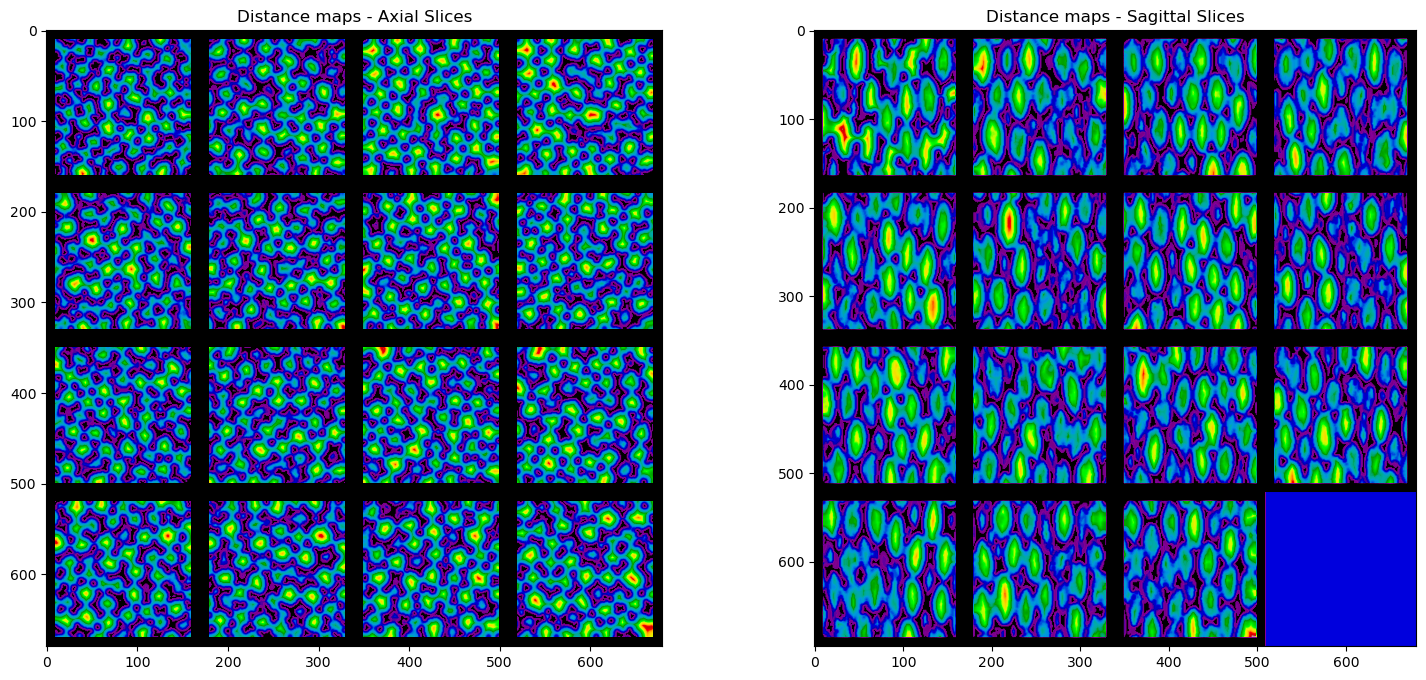

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
ax1.imshow(montage_pad(bubble_dist[::10]), cmap='nipy_spectral')
ax1.set_title('Distance maps - Axial Slices')
ax2.imshow(montage_pad(bubble_dist.swapaxes(0, 1)[::10]), cmap='nipy_spectral')
ax2.set_title('Distance maps - Sagittal Slices'); 

# Thickness in 3D Images


While the examples and demonstrations so far have been shown in 2D, the same exact technique can be applied to 3D data as well. For example for this liquid foam structure
<table>
    <tr>
        <td>
            <img src="figures/3dfoam.png" style="height:300px">
        </td>
                <td>
            <img src="figures/thk3dfoam.png" style="height:300px">
        </td>
    </tr>
</table>

- The thickness can be calculated of the background (air) voxels in the same manner.

- With care, this can be used as a proxy for bubble size distribution in systems where all the bubbles are connected to it is difficult to identify single ones.


### An algorithm to create the 3D thickness map

In [27]:
from skimage.feature import peak_local_max
bubble_candidates = peak_local_max(bubble_dist, min_distance=12)
print('Found', len(bubble_candidates), 'bubbles')

thickness_map = np.zeros(bubble_dist.shape, dtype=np.float32)
xx, yy, zz = np.meshgrid(np.arange(bubble_dist.shape[1]),
                         np.arange(bubble_dist.shape[0]),
                         np.arange(bubble_dist.shape[2])
                         )
# sort candidates by size
sorted_candidates = sorted(
    bubble_candidates, key=lambda xyz: bubble_dist[tuple(xyz)])
for label_idx, (x, y, z) in enumerate(sorted_candidates):
    cur_bubble_radius = bubble_dist[x, y, z]
    cur_bubble = ((xx-float(y))**2 +
                  (yy-float(x))**2 +
                  (zz-float(z))**2) <= cur_bubble_radius**2
    thickness_map[cur_bubble] = cur_bubble_radius

Found 98 bubbles


This algorithm is simplified to speed up the 3D case. It locates the distance peaks of each pore and draws a sphere for each. This approach works under the assumption that the pores are perfect spheres.

### Visualizing the 3D thickness map - max projection

Visualizing 3D information on a 2D screen is a challenge. Here, we use the max projection from in the three principal directions.

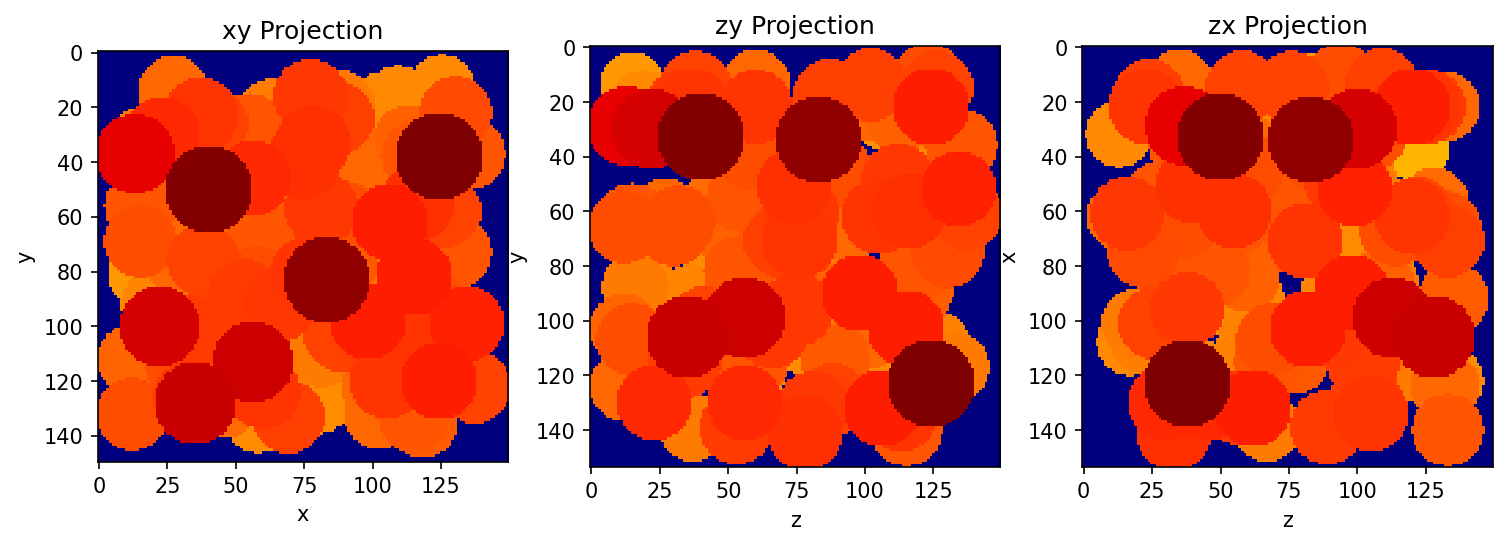

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
for i, (cax, clabel) in enumerate(zip([ax1, ax2, ax3], ['xy', 'zy', 'zx'])):
    cax.imshow(np.max(thickness_map, i).squeeze(),
               interpolation='none', cmap='jet')
    cax.set(title='{} Projection'.format(clabel), xlabel=clabel[0], ylabel=clabel[1]);

### Visualizing the 3D thickness map - mosaic of slices

The max projection looses some information. Showing a selection of slices as a mosaic is sometimes better.

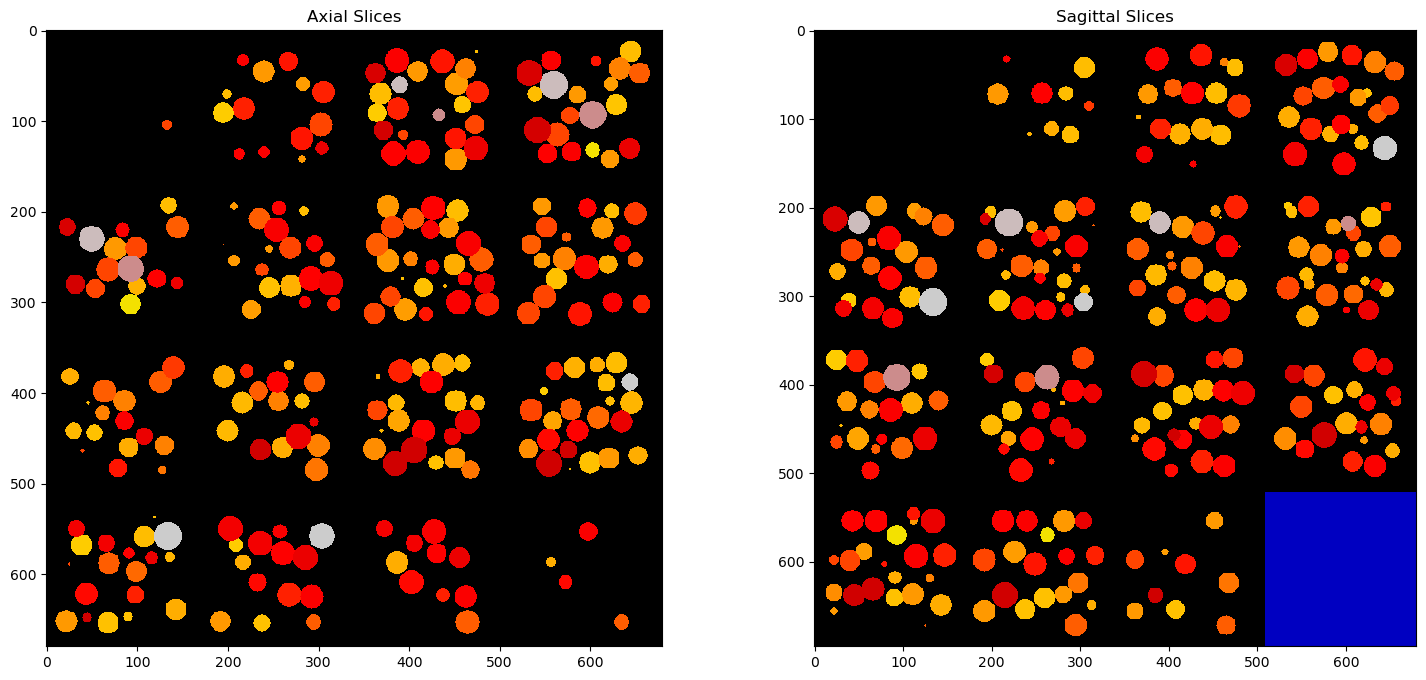

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8),dpi=100)
ax1.imshow(montage_pad(thickness_map[::10]), cmap='nipy_spectral',interpolation="None")
ax1.set_title('Axial Slices')
ax2.imshow(montage_pad(thickness_map.swapaxes(
    0, 1)[::10]), cmap='nipy_spectral',interpolation="None")
ax2.set_title('Sagittal Slices');

# Interactive 3D Views
Here we can show the thickness map in an interactive 3D manner using the ipyvolume tools.

In [30]:
fig = p3.figure()
# create a custom LUT
temp_tf = plt.cm.nipy_spectral(np.linspace(0, 1, 256))
# make transparency more aggressive
temp_tf[:, 3] = np.linspace(-.3, 0.5, 256).clip(0, 1)
tf = p3.transferfunction.TransferFunction(rgba=temp_tf)
p3.volshow((thickness_map[::2, ::2, ::2]/thickness_map.max()).astype(np.float32),
           lighting=True,
           max_opacity=0.5,
           tf=tf,
           controls=True)

p3.show()
p3.save('bubbles.html')

/Users/kaestner/anaconda3/lib/python3.11/site-packages/ipyvolume/serialize.py:102: RuntimeWarning: invalid value encountered in cast
  subdata[..., i] = ((gradient[i][zindex] / 2.0 + 0.5) * 255).astype(np.uint8)


Container(children=[HBox(children=(FloatLogSlider(value=1.0, description='opacity', max=2.0, min=-2.0), FloatL…

# Interfaces / Surfaces

Many physical and chemical processes occur at surfaces and interfaces and consequently these structures are important in material science and biology. For this lecture surface and interface will be used interchangebly and refers to the boundary between two different materials (calcified bone and soft tissue, magma and water, liquid and gas) Through segmentation we have identified the unique phases in the sample under investigation. 

- Segmentation identifying volumes (3D) or areas (2D)
- Interfaces are one dimension lower corresponding to surface area (3D) or perimeter (2D)
- Interfaces are important for 
 - connectivity of cell networks, particularly neurons
 - material science processes like coarsening or rheological behavior
 - chemical processes (surface-bound diffusion, catalyst action)

# Surface Area / Perimeter

We see that the dilation and erosion affects are strongly related to the surface area of an object: 
- the more surface area 
- the larger the effect of a single dilation or erosion step. 


# Meshing

The process of turning a (connected) set of pixels into a list of vertices and edges

- For these vertices and edges we can define forces. 
- Most crucially this comes when looking at physical processes like deformation.
- Meshes are also useful for visualization.

![](figures/Approx-3tori.png)

__Example__

Looking at stress-strain relationships in mechanics using Hooke's Model 

$$ \vec{F}=k (\vec{x}_0-\vec{x}) $$ 

the force needed to stretch one of these edges is proportional to how far it is stretched. 

## Meshing of images


Since we uses voxels to image and identify the volume we can use the voxels themselves as an approimation for the surface of the structure. 
- Each 'exposed' face of a voxel belongs to the surface

From this we can create a mesh by 

- adding each exposed voxel face to a list of surface squares. 
- adding connectivity information for the different squares (shared edges and vertices)

A wide variety of methods of which we will only graze the surface (http://en.wikipedia.org/wiki/Image-based_meshing)

## Marching Cubes

__Why__

Voxels are very poor approximations for the surface and are very rough (they are either normal to the x, y, or z axis and nothing between).

Because of their inherently orthogonal surface normals, any analysis which utilizes the surface normal to calculate another value (growth, curvature, etc) is going to be very inaccurate at best and very wrong at worst.

<img src="../Lecture-04/figures/sphere_comparison.svg" style="height:300px" />

__How__ (https://en.wikipedia.org/wiki/Marching_cubes)

The image is processed one voxel at a time and the neighborhood (not quite the same is the morphological definition) is checked at every voxel. From this configuration of values, faces are added to the mesh to incorporate the most simple surface which would explain the values. 

1. The 2x2x2 neighborhood is checked at every voxel. 
2. Different faces are assigned depending on the neighborhood configuration. 

This algortihm is nicely explained in this [video](https://youtu.be/M3iI2l0ltbE)

[Marching tetrahedra](http://en.wikipedia.org/wiki/Marching_tetrahedra) is for some applications a better suited approach

Curvature
===

Curvature is a metric related to the surface or interface between phases or objects. 
- It is most easily understood in its 1D sense or being the radius of the circle that matchs the local shape of a curve

![Curvature-Wikipedia](http://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Osculating_circle.svg/250px-Osculating_circle.svg.png)

- Mathematically it is defined as 

$$ \kappa = \frac{1}{R} $$

- Thus a low curvature means the value means a very large radius 
- and high curvature means a very small radius

## Curvature: Surface Normal


In order to meaningfully talk about curvatures of surfaces, we first need to define a consistent frame of reference for examining the surface of an object. 

We thus define a surface normal vector as a vector oriented orthogonally to the surface away from the interior of the object $\rightarrow \vec{N}$

<table>
    <tr>
        <td><img src="figures/3Dsurface.png" style="height:600px"></td>
        <td><img src="figures/3DsurfaceWiNormals.png" style="height:600px"></td>
    </tr>
</table>

## Curvature in 3D

With the notion of surface normal defined ($\vec{N}$), we can define many curvatures at point $\vec{x}$ on the surface. 
- This is because there are infinitely many planes which contain both point $\vec{x}$ and $\vec{N}$ 
- More generally we can define an angle $\theta$ about which a single plane containing both can be freely rotated
- We can then define two principal curvatures by taking the maximum and minimum of this curve

$$ \kappa_1 = \textrm{max}(\kappa(\theta)) $$
$$ \kappa_2 = \textrm{min}(\kappa(\theta)) $$

### Mean Curvature
The mean of the two principal curvatures
$$ H = \frac{1}{2}(\kappa_1+\kappa_2) $$

### Gaussian Curvature

The product of the two principal curvatures
$$ K = \kappa_1\kappa_2 $$
- positive for spheres (or spherical inclusions)
 - curvatures agree in sign
- negative for saddles (hyperboloid surfaces)
 - curvatures disgree in sign
- 0 for planes

## Curvature: 3D Examples

Examining a complex structure with no meaningful ellipsoidal or watershed model. 

The images themselves show the type of substructures and shapes which are present in the sample. 

<table>
<tr>
    <th>
    <b>Mean Curvature</b>
    </th>
    <th>
    <b>Gaussian Curvature</b>
    </th>
</tr>
    <tr>
        <td><img src="figures/Complicated3DsurfaceMCurv.png" style="height:400px"></td>
        <td><img src="figures/Complicated3DsurfaceGCurv.png" style="height:400px"></td>
    </tr>
<tr>
<td></td>    
<td>
    
- the comparative amount of surface at, above, and below 0 
- from spherical particles into annealed mesh of balls 

</td>
</tr>
</table>


## Characteristic Shape


Characteristic shape can be calculated by 
- measuring principal curvatures and normalizing them by scaling to the structure size. 
- A distribution of these curvatures then provides shape information on a structure indepedent of the size. 
<br />
<br />
<br />

For example a structure transitioning from a collection of perfectly spherical particles to a annealed solid will go  
- __from__ having many round spherical faces with positive gaussian curvature 
- __to__ many saddles and more complicated structures with 0 or negative curvature.

## Curvature: Take Home Message

It provides another metric for characterizing complex shapes
- Particularly useful for examining interfaces
 - Folds, 
 - saddles, 
 - and many other types of points that are not characterized well with ellipsoids or thickness maps
- Provides a scale-free metric for assessing structures
- Can provide visual indications of structural changes

# Other Techniques

There are hundreds of other techniques which can be applied to these complicated structures, but they go beyond the scope of this course. 

Many of them are model-based which means they work well but only for particular types of samples or images. 

Of the more general techniques several which are easily testable inside of FIJI are 
- Directional Analysis = Looking at the orientation of different components using Fourier analysis (_Analyze_ $\rightarrow$ _Directionality_)
- Tubeness / Surfaceness (_Plugins_ $\rightarrow$ _Analyze_ $\rightarrow$) characterize binary images and the shape at each point similar to curvature but with a different underlying model

## References to other techniques
- Fractal Dimensionality = A metric for assessing the structure as you scale up and down by examining various spatial relationships
 - Ma, D., Stoica, A. D., & Wang, X.-L. (2009). Power-law scaling and fractal nature of medium-range order in metallic glasses. Nature Materials, 8(1), 30–4. doi:10.1038/nmat2340
- Two (or more) point correlation functions = Used in theoretical material science and physics to describe random materials and can be used to characterize distances, orientations, and organization in complex samples 
 - Jiao, Y., Stillinger, F., & Torquato, S. (2007). Modeling heterogeneous materials via two-point correlation functions: Basic principles. Physical Review E, 76(3). doi:10.1103/PhysRevE.76.031110
 - Andrey, P., Kiêu, K., Kress, C., Lehmann, G., Tirichine, L., Liu, Z., … Debey, P. (2010). Statistical analysis of 3D images detects regular spatial distributions of centromeres and chromocenters in animal and plant nuclei. PLoS Computational Biology, 6(7), e1000853. doi:10.1371/journal.pcbi.1000853
 - Haghpanahi, M., & Miramini, S. (2008). Extraction of morphological parameters of tissue engineering scaffolds using two-point correlation function, 463–466. Retrieved from http://portal.acm.org/citation.cfm?id=1713360.1713456
 

 
# Texture Analysis
The world is full of patterns (aka Textures)

<img src="figures/textures.png" style="height:600px" />

[Example taken from](https://www.cs.auckland.ac.nz/~georgy/research/texture/thesis-html/node5.html)

Some metrics to characterize textures
[Haralick texture features](http://murphylab.web.cmu.edu/publications/boland/boland_node26.html) and [DOI](https://doi.org/10.1109/TSMC.1973.4309314)

## Sample Textures

Let's create some sample textures

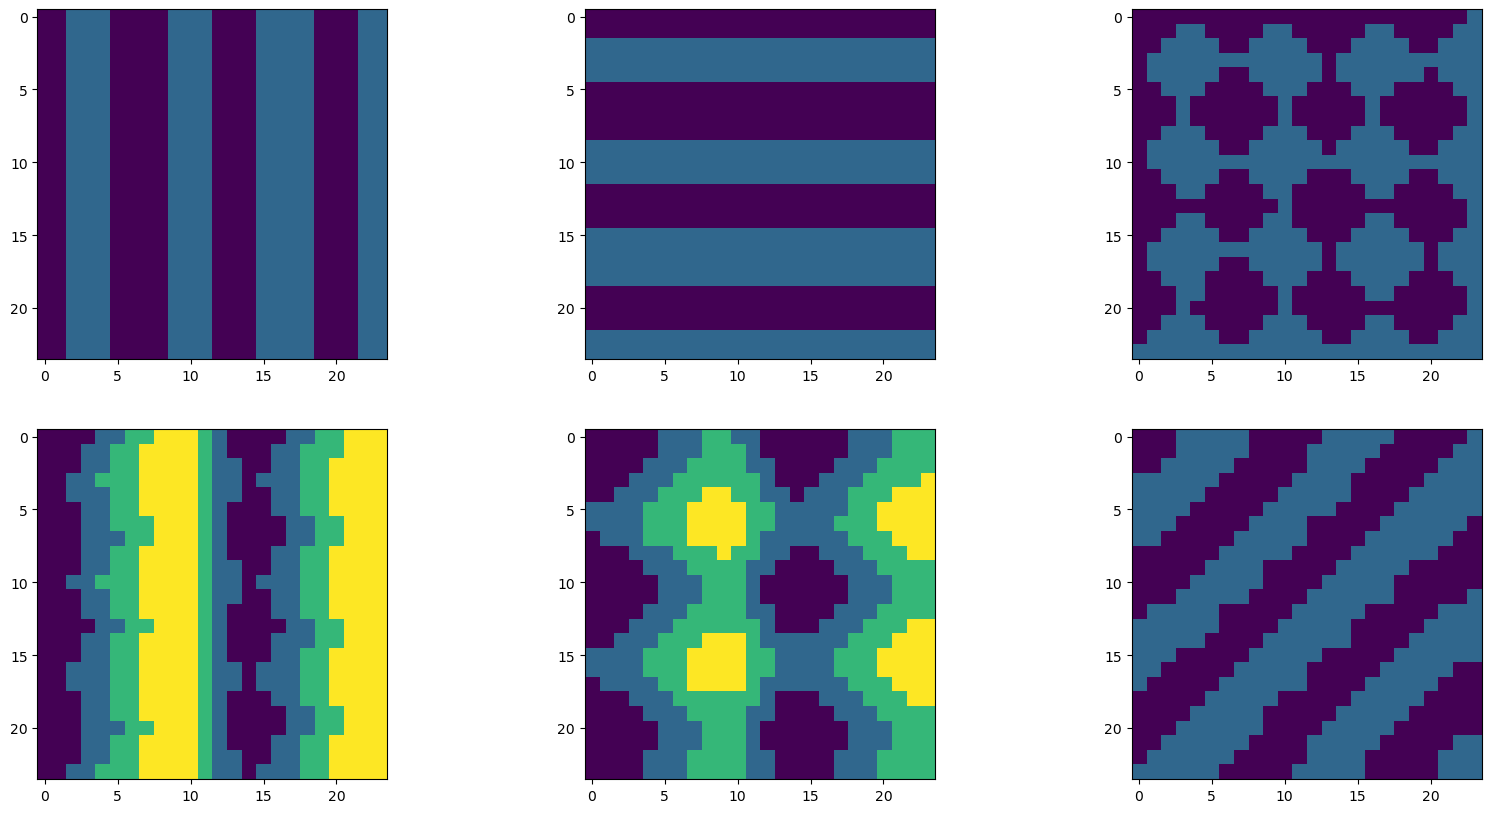

In [31]:
x, y = np.meshgrid(range(8), range(8))

def blur_img(c_img): return (ndimage.zoom(c_img.astype('float'),
                                          3,
                                          order=3,
                                          prefilter=False)*4).astype(int).clip(1, 4)-1

text_imgs = [blur_img(c_img)
             for c_img in [x % 2,
                           y % 2,
                           (x % 2+y % 2)/2.0,
                           (x % 4+y % 2)/2.5,
                           (x % 4+y % 3)/3.5,
                           ((x+y) % 3)/2.0]]

fig, m_axs = plt.subplots(2, 3, figsize=(20, 10))

for c_ax, c_img in zip(m_axs.flatten(), text_imgs):
    c_ax.imshow(c_img,cmap='viridis', vmin=0, vmax=3)

## Methods to characterize textures: Co-occurrence matrix


$$
C_{\Delta x, \Delta y}(i,j)=\sum_{x=1}^n\sum_{y=1}^m\begin{cases} 1, & \text{if }I(x, y)=i\text{ and }I(x+\Delta x, y+\Delta y)=j \\ 0, & \text{otherwise}\end{cases}
$$

As text $\rightarrow$ 

- for every possible offset $\vec{r}$ = ($\Delta x$, $\Delta y$) given the current intensity ($i$) how likely is it that value at a point offset by that amount is $j$.
- This is similar to the two point correlation function but is a 4D representation instead of just a 2D
- In order to use this we need to discretize the image into bins

In [32]:
def montage_nd(in_img):
    if len(in_img.shape) > 3:
        return montage2d(np.stack([montage_nd(x_slice) for x_slice in in_img], 0))
    elif len(in_img.shape) == 3:
        return montage2d(in_img)
    else:
        warn('Input less than 3d image, returning original', RuntimeWarning)
        return in_img


dist_list  = np.linspace(1, 6, 15)
angle_list = np.linspace(0, 2*np.pi, 15)

def calc_coomatrix(in_img):
    return graycomatrix(image=in_img,
                        distances=dist_list,
                        angles=angle_list,
                        levels=4)

def coo_tensor_to_df(x): return pd.DataFrame(
    np.stack([x.ravel()]+[c_vec.ravel() for c_vec in np.meshgrid(range(x.shape[0]),
                                                                 range(x.shape[1]),
                                                                 dist_list,
                                                                 angle_list,
                                                                 indexing='xy')], -1),
    columns=['E', 'i', 'j', 'd', 'theta'])


coo_tensor_to_df(calc_coomatrix(text_imgs[0])).sample(5)

E    i    j         d     theta
2578    0.0  3.0  2.0  3.142857  5.834386
1986    0.0  0.0  2.0  5.285714  2.692794
3064    0.0  1.0  3.0  4.214286  1.795196
1032  126.0  0.0  1.0  3.857143  5.385587
2474    0.0  2.0  2.0  6.000000  6.283185

### Co-occurence matrices for the test patterns
Using 
- 4 levels
- 15 Distances
- 15 Directions

> The value P[i,j,d,theta] is the number of times that gray-level j occurs at a distance d and at an angle theta from gray-level i. 

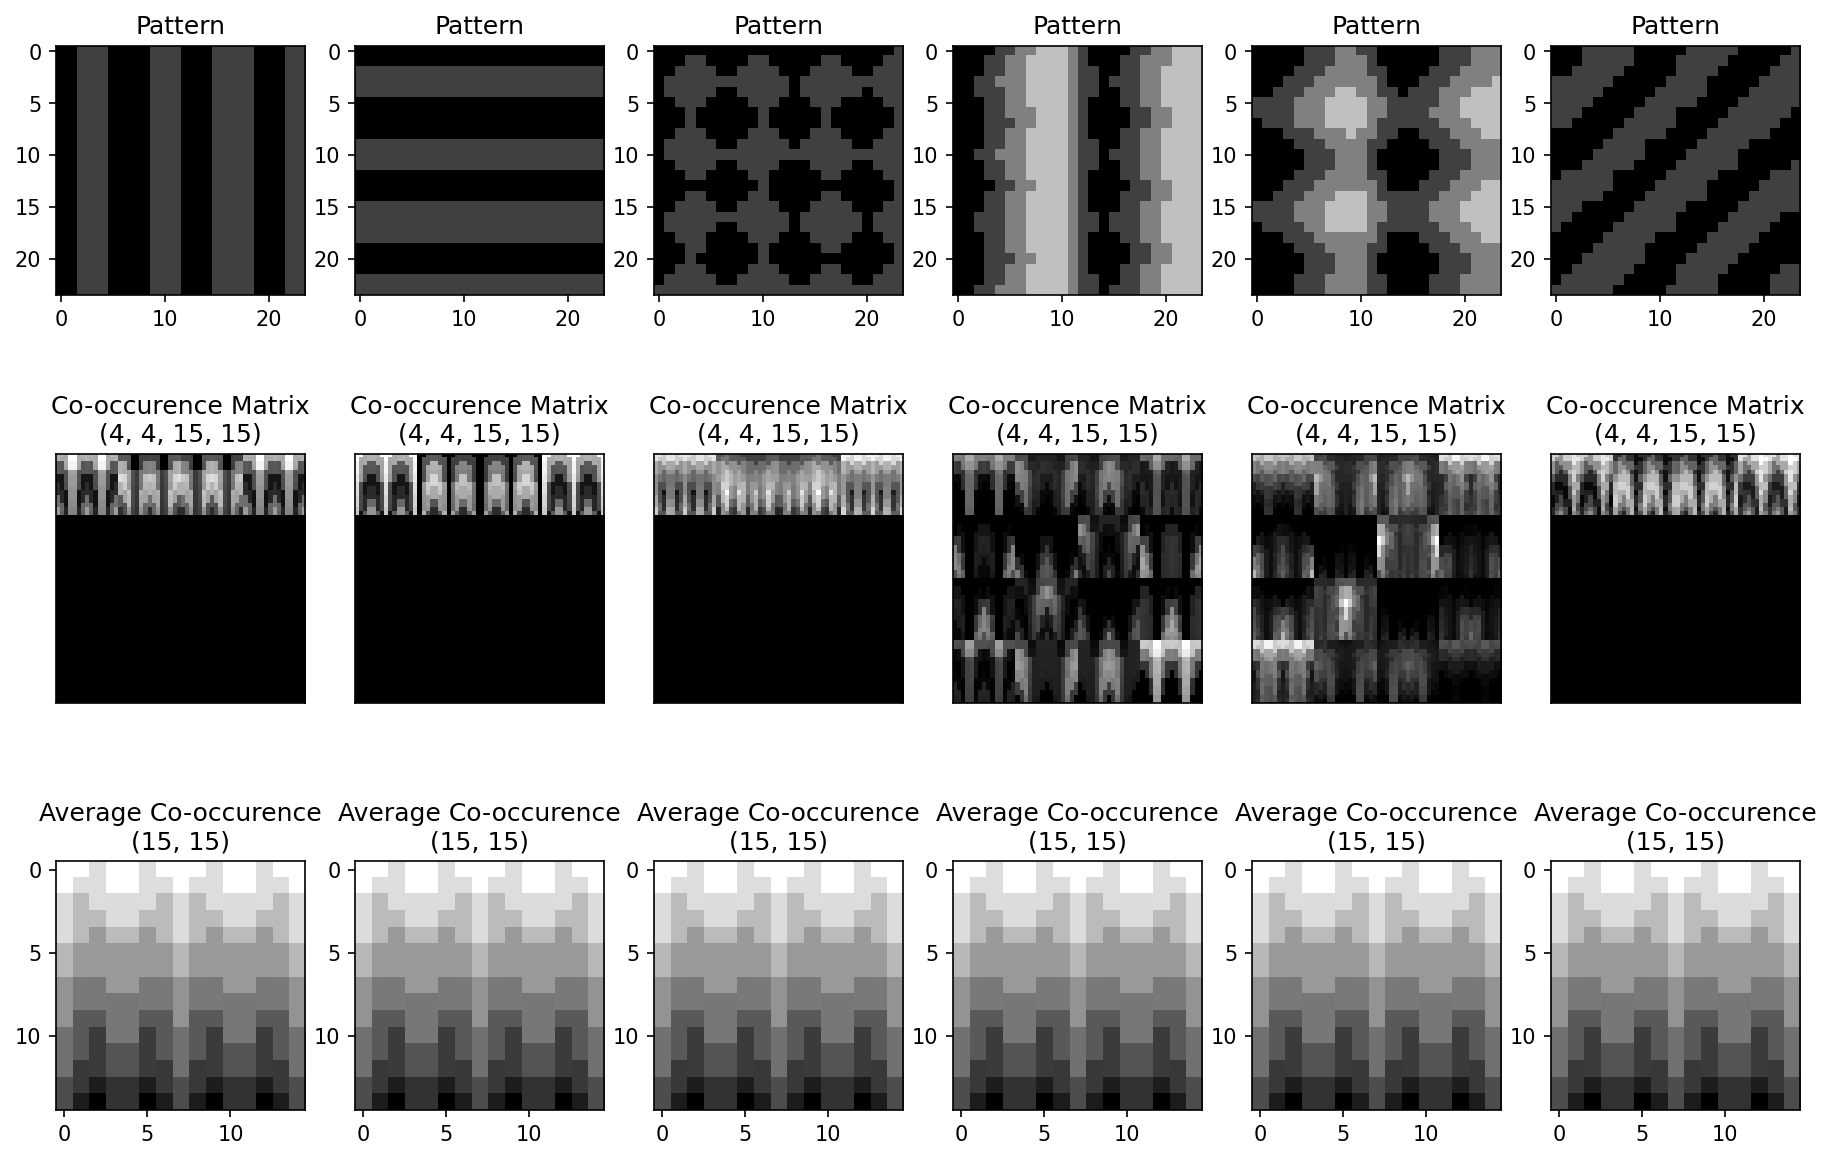

In [33]:
fig, m_axs = plt.subplots(3, 6, figsize=(15, 10), dpi=150)

for (c_ax, d_ax, f_ax), c_img in zip(m_axs.T, text_imgs):
    c_ax.imshow(c_img, vmin=0, vmax=4, cmap='gray'); c_ax.set_title('Pattern')
    full_coo_matrix = calc_coomatrix(c_img)
    d_ax.imshow(montage_nd(full_coo_matrix), cmap='gray')
    d_ax.set(title='Co-occurence Matrix\n{}'.format(full_coo_matrix.shape),xticks=[],yticks=[])
    avg_coo_matrix = np.mean(full_coo_matrix*1.0, axis=(0, 1))
    f_ax.imshow(avg_coo_matrix, cmap='gray')
    f_ax.set_title('Average Co-occurence\n{}'.format(avg_coo_matrix.shape))

Here, you can see that the bi-level images only have a single row in the montage. This is because there is no additional co-occurance for greater gray level differences.

## Simple Correlation

Using the mean difference ($E[i-j]$) instead of all of the i,j pair possiblities 

In [34]:
text_df = coo_tensor_to_df(calc_coomatrix(text_imgs[0]))
text_df['ij_diff'] = text_df.apply(lambda x: x['i']-x['j'], axis=1)

simple_corr_df = text_df.groupby(['ij_diff', 'd', 'theta']).agg({'E': 'mean'}).reset_index()
simple_corr_df.sample(5).round(decimals=3)

ij_diff      d  theta    E
355      -2.0  3.857  4.488  0.0
334      -2.0  3.500  1.795  0.0
185      -3.0  5.286  2.244  0.0
1469      3.0  3.500  6.283  0.0
1419      3.0  2.429  4.039  0.0

### Inspecting the mean difference

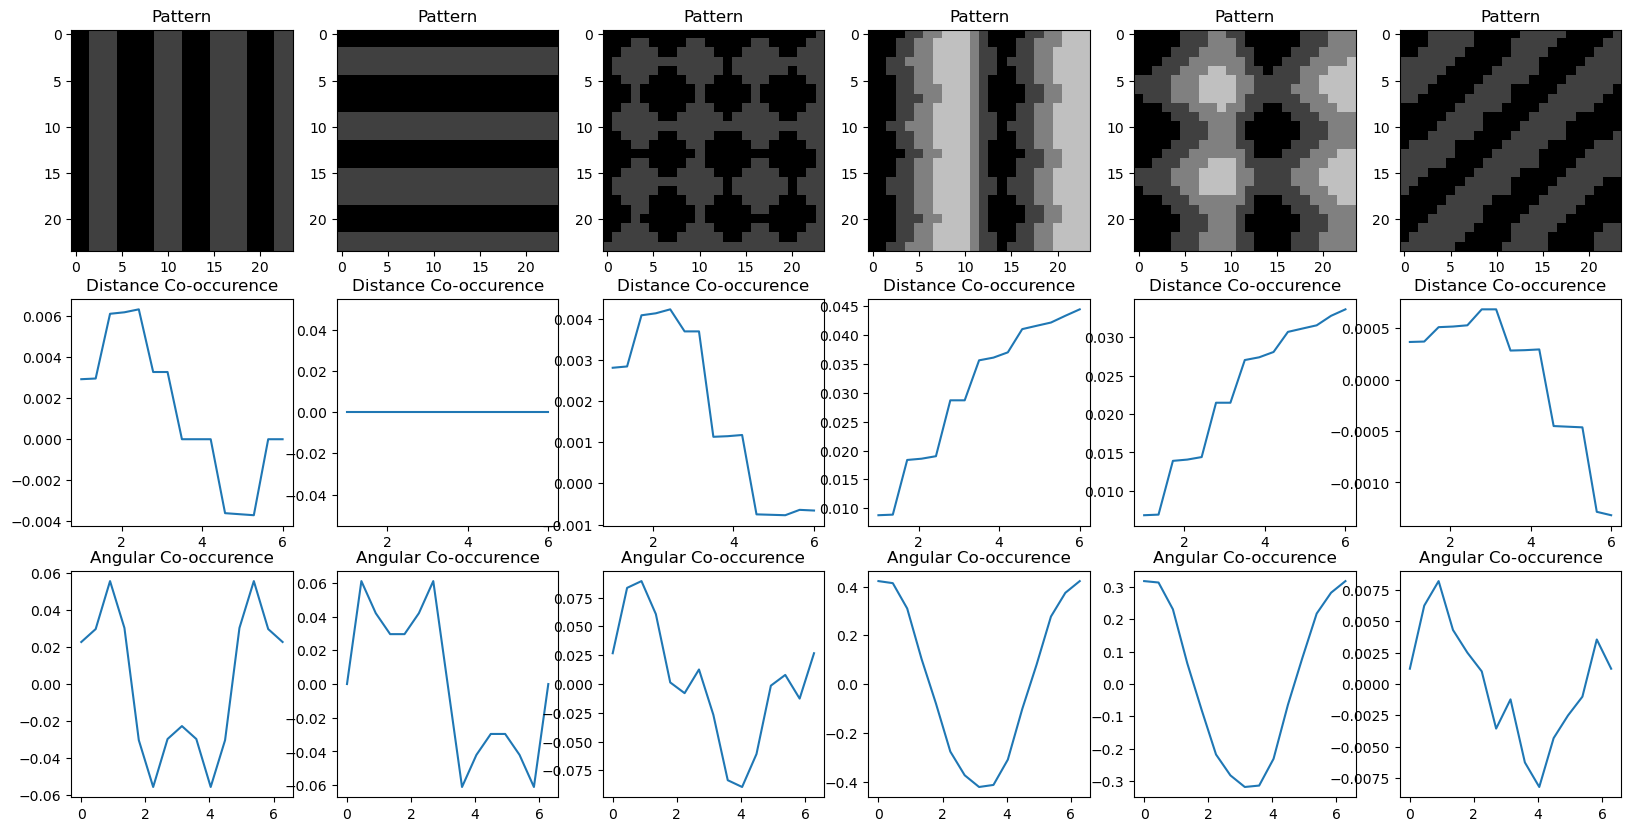

In [35]:
def grouped_weighted_avg(values, weights, by):
    return (values * weights).groupby(by).sum() / weights.groupby(by).sum()


fig, m_axs = plt.subplots(3, 6, figsize=(20, 10))

for (c_ax, d_ax, f_ax), c_img in zip(m_axs.T, text_imgs):
    c_ax.imshow(c_img, vmin=0, vmax=4, cmap='gray')
    c_ax.set_title('Pattern')
    full_coo_matrix = calc_coomatrix(c_img)
    text_df = coo_tensor_to_df(full_coo_matrix)
    text_df['ij_diff'] = text_df.apply(lambda x: x['i']-x['j'], axis=1)

    simple_corr_df = text_df.groupby(['ij_diff', 'd', 'theta']).agg({
        'E': 'sum'}).reset_index()
    gwa_d = grouped_weighted_avg(
        simple_corr_df.ij_diff, simple_corr_df.E, simple_corr_df.d)
    d_ax.plot(gwa_d.index, gwa_d.values)
    d_ax.set_title('Distance Co-occurence')

    gwa_theta = grouped_weighted_avg(
        simple_corr_df.ij_diff, simple_corr_df.E, simple_corr_df.theta)
    f_ax.plot(gwa_theta.index, gwa_theta.values)
    f_ax.set_title('Angular Co-occurence')

## Applying texture analysis to microscope image
We want to segment different regions in a [microscope image from a sea urchin](https://www.sciencenews.org/article/sea-urchin-skeletons-patterns-structure)

In [36]:
photo = io.imread('figures/Tripneustes_ventricosus.jpg')
img   = io.imread('data/sea-urchin-skeleton.jpg').mean(axis=2).astype(int)
mask  = io.imread('data/sea-urchin-skeleton_feat.png')

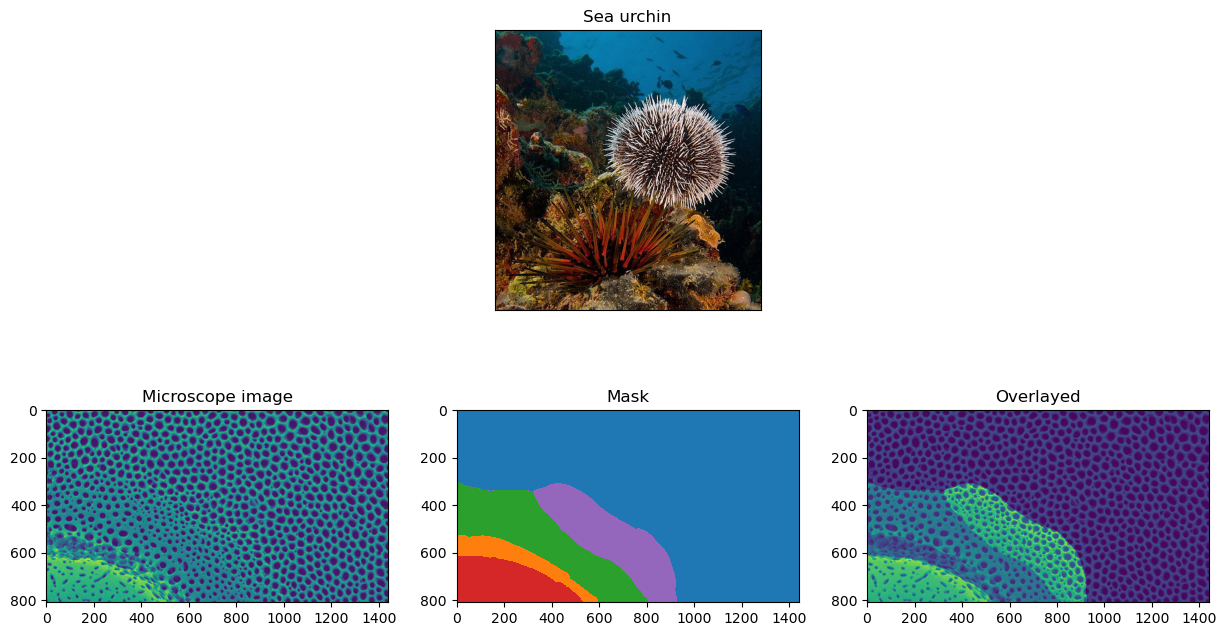

In [37]:
fig, ax = plt.subplots(2,3,figsize=(15,8))
mask[0,0]=10
ax=ax.ravel()
ax[0].axis('off')
ax[1].imshow(photo)
ax[1].set(title="Sea urchin",xticks=[],yticks=[])
ax[2].axis('off')
ax[3].imshow(img,cmap='viridis')
ax[3].set_title('Microscope image')
ax[4].imshow(mask,cmap='tab10',interpolation='none')
ax[4].set_title('Mask');
ax[5].imshow((20*mask+50)*img,cmap='viridis')
ax[5].set_title('Overlayed');

The regions are among others characterized by the pore shape and size distributions. 
> Let's try texture analysis!

### Analysis workflow

![](figures/TextureFlowChart.png)

## Tiling the image
Here we divide the image up into unique tiles for further processing. Each tile is 48$\times{}$48 pixels.

In [38]:
xx, yy = np.meshgrid(
    np.arange(img.shape[1]),
    np.arange(img.shape[0]))
N=90 # one of [ 1,  2,  3,  5,  6,  9, 10, 15, 18, 30, 45, 90]
M=810/N
region_labels = (xx//N) * M+yy//N
region_labels = region_labels.astype(int)

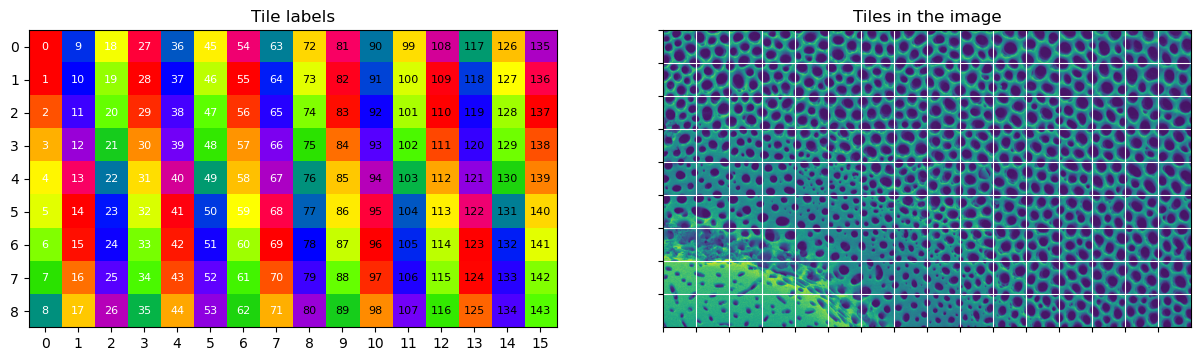

In [39]:
fig,ax = plt.subplots(1,2,figsize=(15,7))

ps.heatmap(region_labels[::N, ::N].astype(int),precision=0,cmap="prism", fontsize=8,ax=ax[0],bgbox=False)

ax[0].set_title('Tile labels')

ax[1].imshow(img,cmap='viridis')
ax[1].set(xticks=(np.arange(0,img.shape[1],N)),yticks=(np.arange(0,img.shape[0],N)),
          xticklabels=[],yticklabels=[],
          title='Tiles in the image')
ax[1].grid(visible=True, which='major', axis='both',color='white')


### Gray-level colocation properties

In [40]:
grayco_prop_list = ['contrast', 
                    'dissimilarity',
                    'homogeneity', 
                    #'energy',   # = sqrt(ASM) ... skipped
                    'correlation', 
                    'ASM']

### Compute the feature vectors
For each tile compute
- Gray-level co-occurance matrix
- Average label
- Mean and standard deviation of gray-level
- Gray-level co-occurance propoerties

and store in a dictionary.

#### The code

In [41]:
# Initialization
prop_imgs = {}
for c_prop in grayco_prop_list:
    prop_imgs[c_prop] = np.zeros_like(img, dtype=np.float32)
score_img = np.zeros_like(img, dtype=np.float32)
out_df_list = []

# For each tile... compute colocation matrix and properties
for patch_idx in np.unique(region_labels):
    xx_box, yy_box = np.where(region_labels == patch_idx)

    glcm = graycomatrix(img[xx_box.min():xx_box.max(),yy_box.min():yy_box.max()],
                        [4,8,16], np.linspace(0,np.pi,6), 256, symmetric=False, normed=True)

    mean_score = np.round(np.mean(mask[region_labels == patch_idx]))
    score_img[region_labels == patch_idx] = mean_score

    out_row = dict(
        intensity_mean = img[region_labels == patch_idx].mean(),
        intensity_std  = img[region_labels == patch_idx].std(),
        score          = mean_score)

    for c_prop in grayco_prop_list:
        out_row[c_prop] = graycoprops(glcm, c_prop)[0, 0]
        prop_imgs[c_prop][region_labels == patch_idx] = out_row[c_prop]

    out_df_list += [out_row];

### The resulting feature images

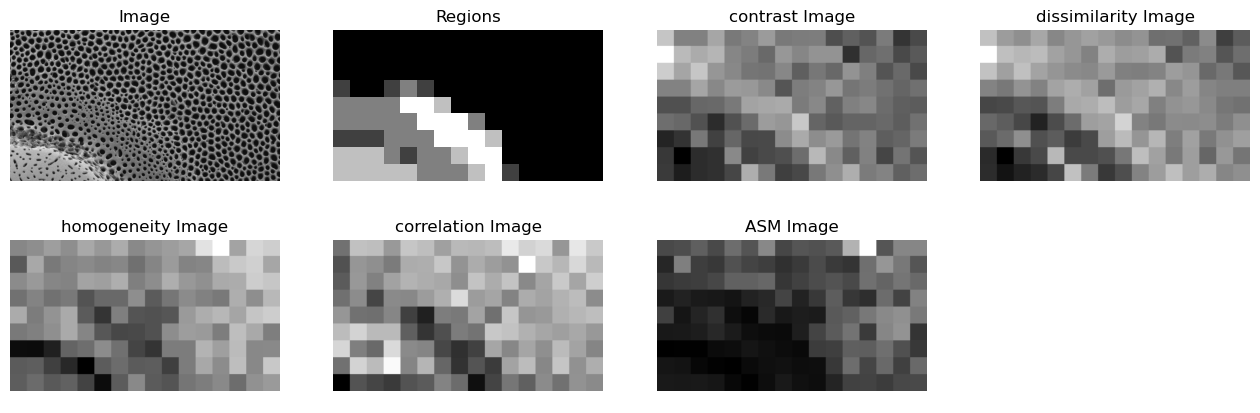

In [42]:
# show the slice and threshold
fig, m_axs = plt.subplots(2, 4, figsize=(16, 5))
ax = m_axs.flatten()
ax[0].imshow(img, cmap='gray')
ax[0].axis('off')
ax[0].set_title('Image')
ax[1].imshow(score_img, cmap='gray',interpolation='none')
ax[1].axis('off')
ax[1].set_title('Regions')
for c_ax, c_prop in zip(ax[2:], grayco_prop_list):
    c_ax.imshow(prop_imgs[c_prop], cmap='gray')
    c_ax.axis('off')
    c_ax.set_title('{} Image'.format(c_prop))

ax[7].axis('off');

### Summarizing the statistics

In [43]:
out_df = pd.DataFrame(out_df_list)
out_df.describe()

intensity_mean  intensity_std       score     contrast  dissimilarity  \
count      144.000000     144.000000  144.000000   144.000000     144.000000   
mean       124.780106      39.216082    0.888889   837.406576      19.228806   
std         14.221951       4.056652    1.343782   163.129731       2.455831   
min        109.707654      26.468436    0.000000   368.159022      11.707204   
25%        116.853920      38.061432    0.000000   736.890218      17.876735   
50%        120.748765      40.187202    0.000000   844.649570      19.582353   
75%        126.503488      41.980307    2.000000   924.919002      20.876570   
max        181.460617      45.414126    4.000000  1409.422340      26.451553   

       homogeneity  correlation         ASM  
count   144.000000   144.000000  144.000000  
mean      0.134878     0.725910    0.002449  
std       0.025904     0.049160    0.001557  
min       0.058498     0.574036    0.000219  
25%       0.119806     0.698575    0.001119  
50%       0.136841     0.731594    0.002368  
75%       0.152959     0.762922    0.003473  
max       0.206492     0.834216    0.009360

### Comparing the features pairwise

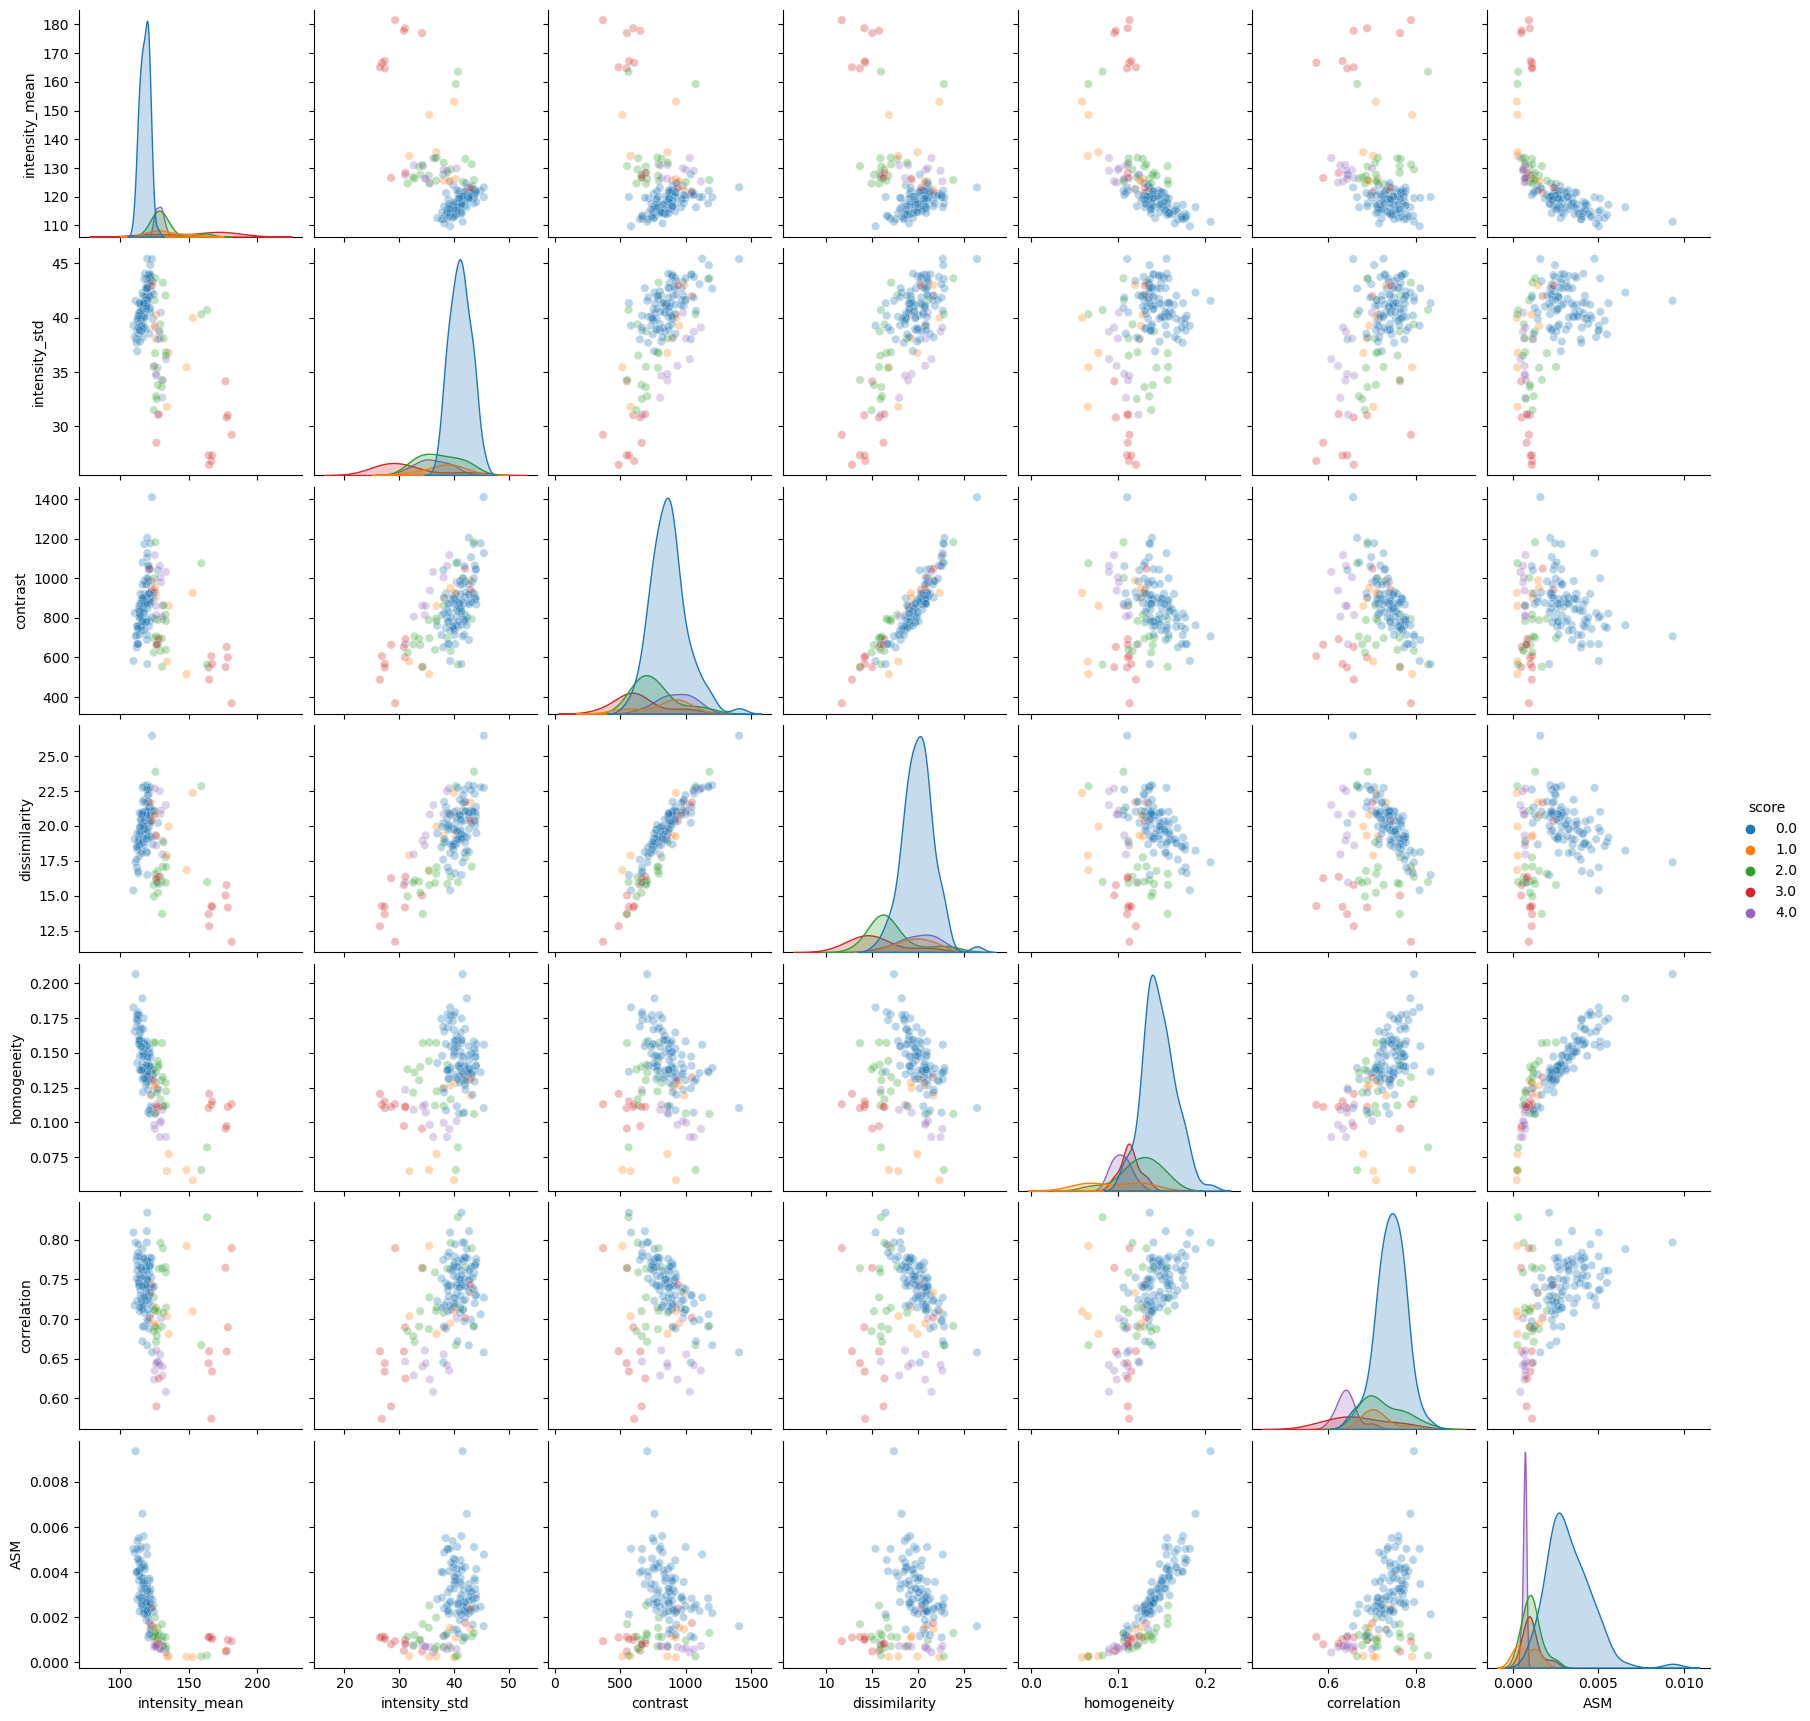

In [44]:
sns.pairplot(out_df,hue='score',plot_kws={'alpha': 0.3}, palette=sns.color_palette("tab10")[0:5]);

### A closer look

Let's look at mean and std deviation only for each class

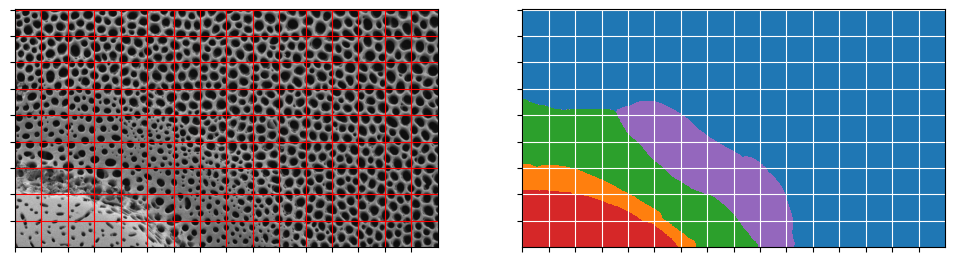

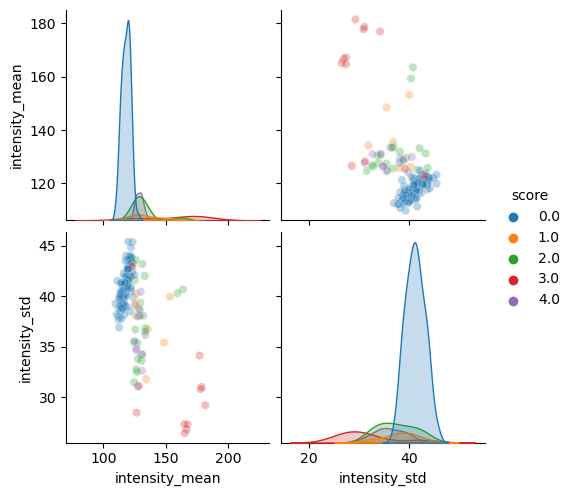

In [51]:
fig,ax=plt.subplots(1,2,figsize=(12,4))
ax[0].imshow(img, cmap='gray')
ax[0].set_xticks(np.arange(0,img.shape[1],N))
ax[0].set_yticks(np.arange(0,img.shape[0],N))
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].grid(visible=True, which='major', axis='both',color='red')

ax[1].imshow(mask, cmap='tab10',interpolation='none')
ax[1].set_xticks(np.arange(0,img.shape[1],N))
ax[1].set_yticks(np.arange(0,img.shape[0],N))
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].grid(visible=True, which='major', axis='both',color='white')

sns.pairplot(out_df,vars=['intensity_mean','intensity_std'],hue='score',plot_kws={'alpha': 0.3}, palette=sns.color_palette("tab10")[0:5]);

## Applying Texture analysis to Brain

In [ ]:
cortex_img = np.clip(imread("figures/example_poster.tif")
                     [::2, ::2]/270, 0, 255).astype(np.uint8)

cortex_mask = imread("figures/example_poster_mask.tif")[::1, ::1, 0]/255.0

# show the slice and threshold
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(11, 5),dpi=100)
ax1.imshow(cortex_img, cmap='gray'); ax1.axis('off') ; ax1.set_title('Image')
ax2.imshow(cortex_mask, cmap='gray'); ax2.axis('off'); ax2.set_title('Segmentation')
# here we mark the threshold on the original image

ax3.imshow(label2rgb(cortex_mask > 0, cortex_img, bg_label=0))
ax3.axis('off'); ax3.set_title('Overlayed');

## Tiling the image
Here we divide the image up into unique tiles for further processing. Each tile is 48$\times{}$48 pixels.

In [ ]:
xx, yy = np.meshgrid(
    np.arange(cortex_img.shape[1]),
    np.arange(cortex_img.shape[0]))
region_labels = (xx//48) * 64+yy//48
region_labels = region_labels.astype(int)
sns.heatmap(region_labels[::48, ::48].astype(int),
            annot=True,
            fmt="03d",
            cmap='nipy_spectral',
            cbar=False,
            );

## Calculating Texture
Here we calculate the texture by using a tool called the gray level co-occurrence matrix which are part of the [features library in skimage][1]. We focus on two metrics in this, specifically dissimilarity and correlation which we calculate for each tile. We then want to see which of these parameters correlated best with belonging to a nerve fiber.


  [1]: http://scikit-image.org/docs/dev/auto_examples/features_detection/plot_glcm.html

In [ ]:
# compute some gray level co-occurrence matrix (GLCM) properties each patch
from skimage.feature import greycomatrix, greycoprops
from tqdm.notebook import tqdm
grayco_prop_list = ['contrast', 'dissimilarity',
                    'homogeneity', 'energy',
                    'correlation', 'ASM']

prop_imgs = {}
for c_prop in grayco_prop_list:
    prop_imgs[c_prop] = np.zeros_like(cortex_img, dtype=np.float32)
score_img = np.zeros_like(cortex_img, dtype=np.float32)
out_df_list = []
for patch_idx in np.unique(region_labels):
    xx_box, yy_box = np.where(region_labels == patch_idx)

    glcm = greycomatrix(cortex_img[xx_box.min():xx_box.max(),
                                   yy_box.min():yy_box.max()],
                        [5], [0], 256, symmetric=True, normed=True)

    mean_score = np.mean(cortex_mask[region_labels == patch_idx])
    score_img[region_labels == patch_idx] = mean_score

    out_row = dict(
        intensity_mean=np.mean(cortex_img[region_labels == patch_idx]),
        intensity_std=np.std(cortex_img[region_labels == patch_idx]),
        score=mean_score)

    for c_prop in grayco_prop_list:
        out_row[c_prop] = greycoprops(glcm, c_prop)[0, 0]
        prop_imgs[c_prop][region_labels == patch_idx] = out_row[c_prop]

    out_df_list += [out_row];

### Resulting gray level co-occurrence properties

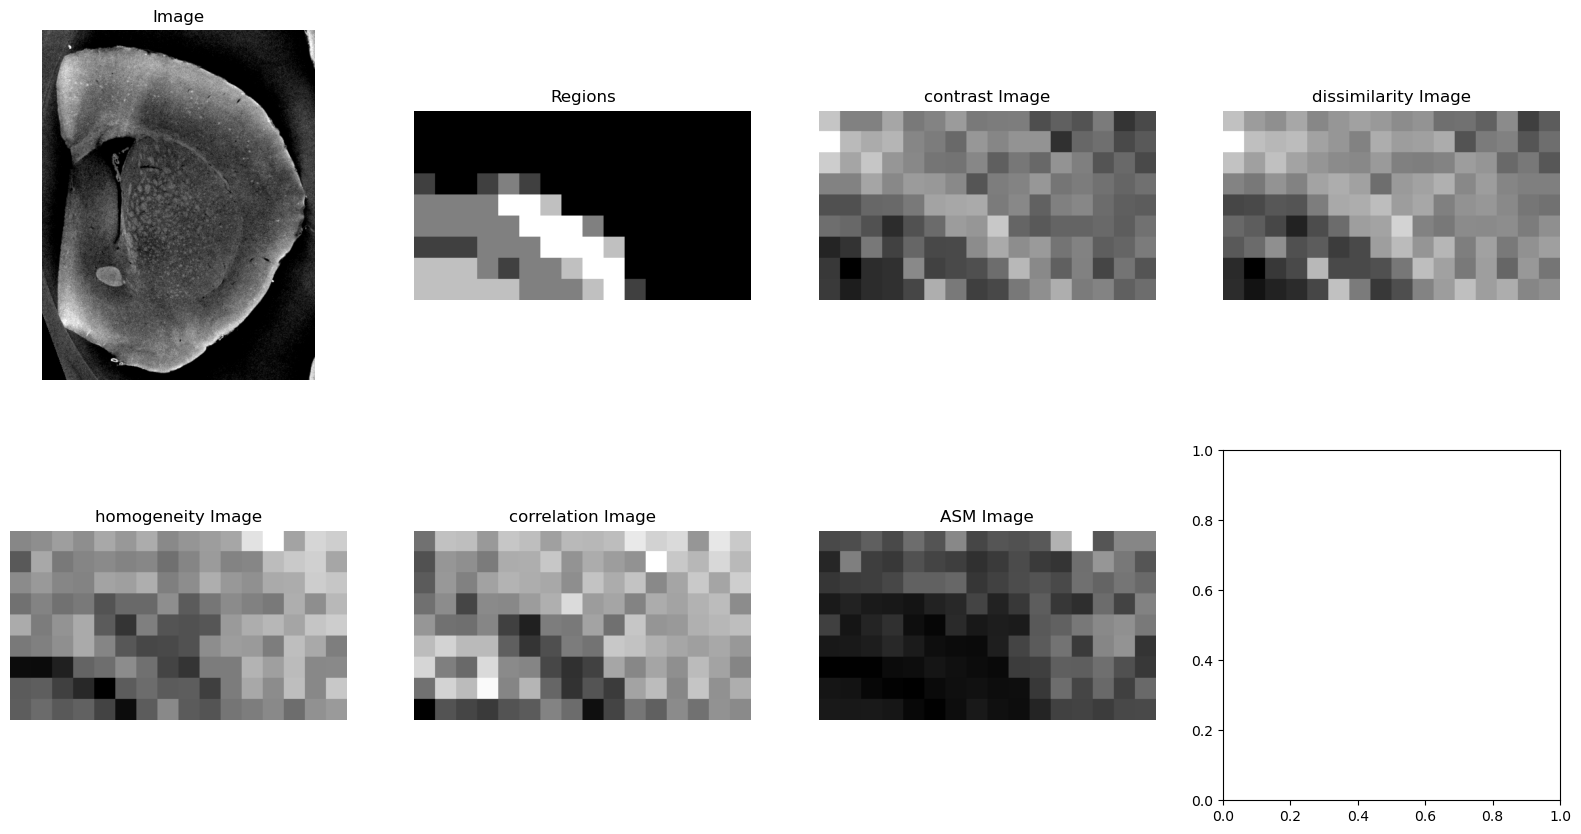

In [45]:
# show the slice and threshold
fig, m_axs = plt.subplots(2, 4, figsize=(20, 10))
n_axs = m_axs.flatten()
ax1 = n_axs[0]
ax2 = n_axs[1]
ax1.imshow(cortex_img, cmap='gray')
ax1.axis('off')
ax1.set_title('Image')
ax2.imshow(score_img, cmap='gray')
ax2.axis('off')
ax2.set_title('Regions')
for c_ax, c_prop in zip(n_axs[2:], grayco_prop_list):
    c_ax.imshow(prop_imgs[c_prop], cmap='gray')
    c_ax.axis('off')
    c_ax.set_title('{} Image'.format(c_prop))

### Resulting gray level co-occurrence properties

In [46]:
import pandas as pd
out_df = pd.DataFrame(out_df_list)
out_df['positive_score'] = out_df['score'].map(
    lambda x: 'FG' if x > 0 else 'BG')
out_df.describe()

intensity_mean  intensity_std       score     contrast  dissimilarity  \
count      144.000000     144.000000  144.000000   144.000000     144.000000   
mean       124.780106      39.216082    0.888889   837.406576      19.228806   
std         14.221951       4.056652    1.343782   163.129731       2.455831   
min        109.707654      26.468436    0.000000   368.159022      11.707204   
25%        116.853920      38.061432    0.000000   736.890218      17.876735   
50%        120.748765      40.187202    0.000000   844.649570      19.582353   
75%        126.503488      41.980307    2.000000   924.919002      20.876570   
max        181.460617      45.414126    4.000000  1409.422340      26.451553   

       homogeneity  correlation         ASM  
count   144.000000   144.000000  144.000000  
mean      0.134878     0.725910    0.002449  
std       0.025904     0.049160    0.001557  
min       0.058498     0.574036    0.000219  
25%       0.119806     0.698575    0.001119  
50%       0.136841     0.731594    0.002368  
75%       0.152959     0.762922    0.003473  
max       0.206492     0.834216    0.009360

### A pair plot to show how the properties are related

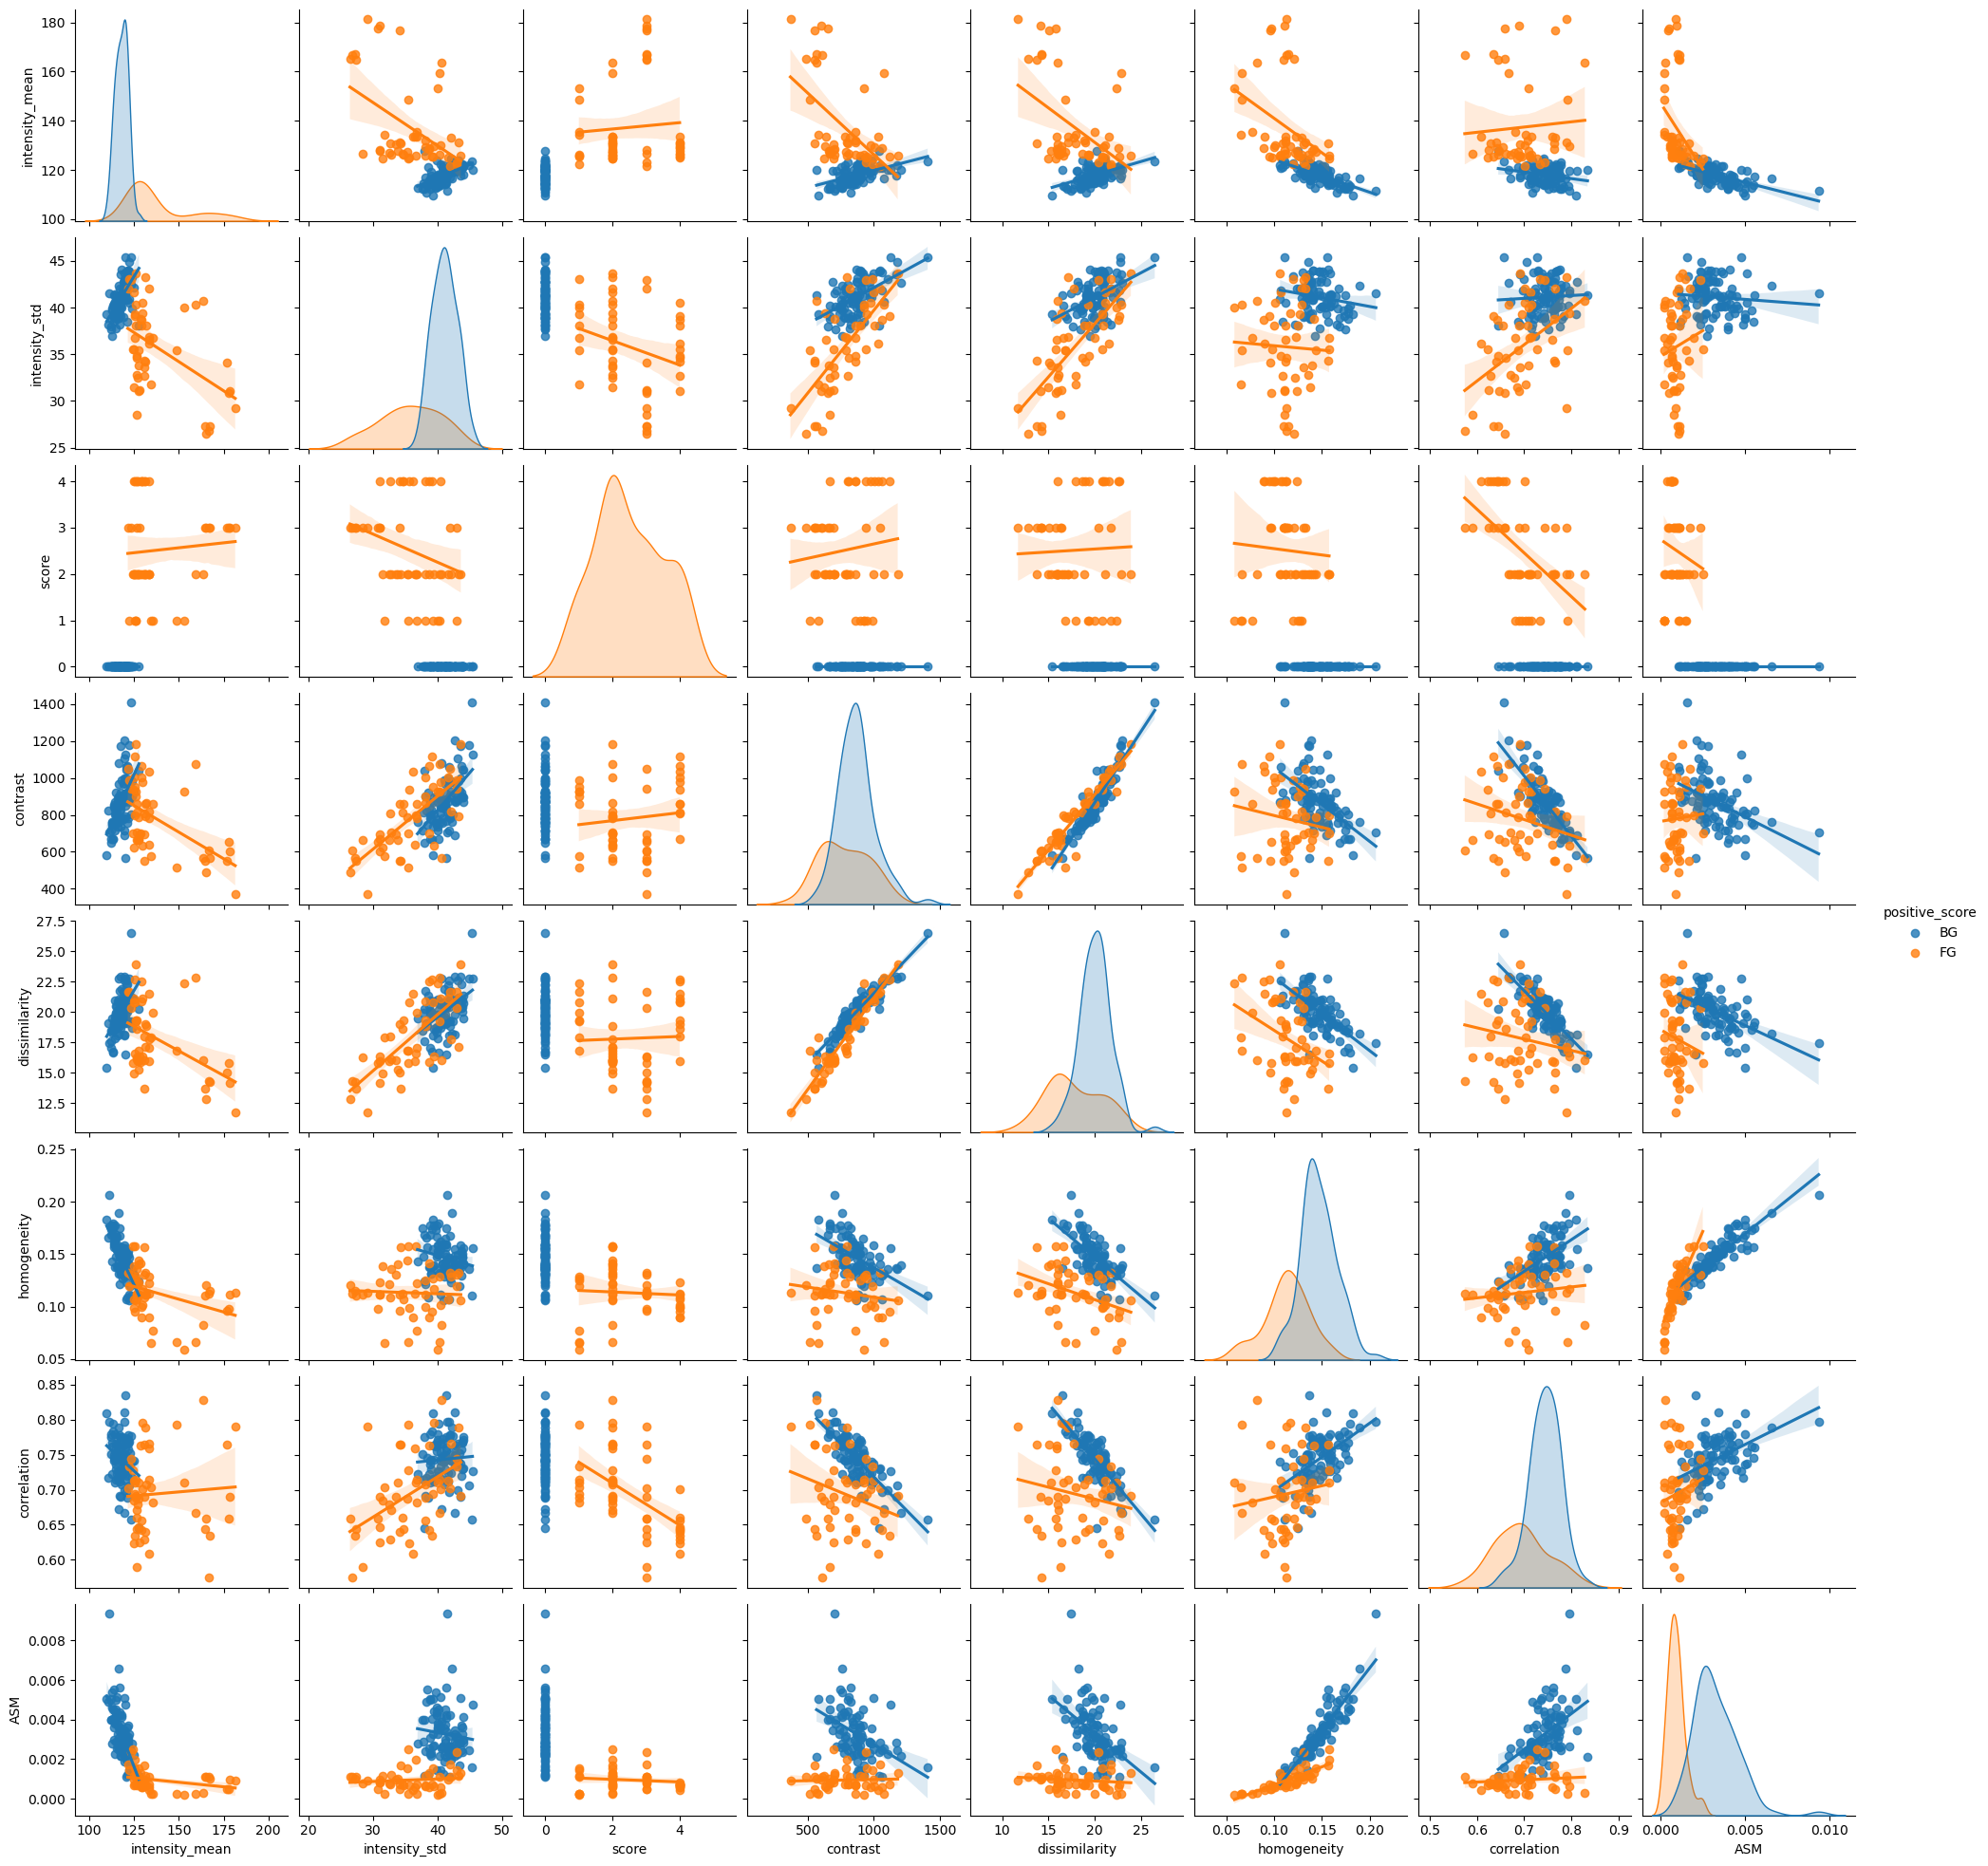

In [47]:
sns.pairplot(out_df, hue='positive_score', kind="reg");

# Summary

## Distance maps
- Definition
- Importance of neighborhood
- Thickness/Pore radius map

## Visualizing 3D data
- Meshes
- Surfaces
- Tools in python

## Surface description
- Curvatures

## Texture
- Textures are patterns in images
- Measure texture characteristics